# Importing packages

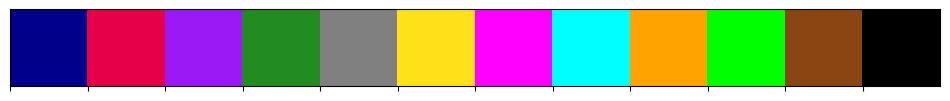

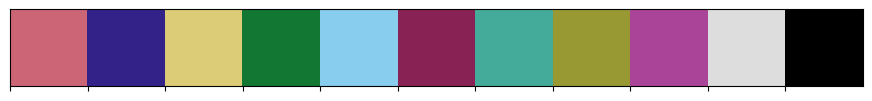

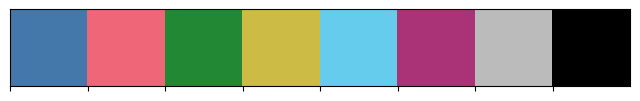

In [1]:
from glob import glob
import itertools
import warnings

warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import imageio
from matplotlib.image import NonUniformImage
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_BRIGHT as PTB
from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.manage import utilizer 
from polyphys.manage.parser import HnsCyl, HnsCub
from polyphys.analyze import clusters
from polyphys.analyze import measurer
import warnings
warnings.filterwarnings("ignore")
database = '../../Datasets/'
#database = '/Users/amirhsi_mini/research_data/analysis/'
sns.palplot(AC)
sns.palplot(PTM)
sns.palplot(PTB)

In [ ]:
rocket_r_cmap = mpl.colors.ListedColormap(list(reversed(sns.cm._rocket_lut)))
rocket_r_cmap_cut = tuner.truncated_colormap(rocket_r_cmap,  min_value=.05, max_value=1)
mpl.cm.register_cmap("rocket_r_cmap_cut", rocket_r_cmap_cut)

## Simulation inputs

In [ ]:

# h-ns molar concentration:
n_avogardro = 6.02214076 * 10**23
sigma_to_m = 2.5*10**-9
mole_per_m_to_mole_per_litre = 10**3
mole_per_litre_to_micro_mole_per_liter = 10**-6
phi_c = np.array([0, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4])
nhns = np.array([0, 4, 8, 12 ,16, 20, 30])
dcrowd = 1
vcrowd = np.pi * dcrowd**3 / 6
dcrowd_d = 2
vcrowd_d = np.pi * dcrowd_d**3 / 6
# cubic geometry:
print("cubic geometry")
lcube = 50
vcube = lcube ** 3
n_c_bulk = np.round(phi_c * vcube / vcrowd)
print("ncrowd for dcrowd=1:", n_c_bulk)
rho_hns_bulk = (nhns / vcube)
c_hns_bulk = np.round(rho_hns_bulk / n_avogardro / sigma_to_m**3, 6) / mole_per_m_to_mole_per_litre / mole_per_litre_to_micro_mole_per_liter
print("c_hns_bulk: ", c_hns_bulk)
# cylindrical geometry:
print("cylindrical geometry")
dcyl = 15
lcyl = 3*419
vcyl = np.pi * dcyl**2 * lcyl / 4
n_c_bulk = np.round(phi_c * vcyl / vcrowd)
print("ncrowd for dcrowd=1:", n_c_bulk)
n_c_bulk_d = np.round(phi_c * vcyl / vcrowd_d)
print("ncrowd for dcrowd=2:", n_c_bulk_d)
rho_hns_bulk = (nhns / vcyl)
c_hns_bulk = np.round(rho_hns_bulk / n_avogardro / sigma_to_m**3, 6) / mole_per_m_to_mole_per_litre / mole_per_litre_to_micro_mole_per_liter
print("c_hns_bulk: ", c_hns_bulk)


In [ ]:
250000/0.01 + 10000000

#### $N=1000, D=15$:

In [ ]:
n_kbmm = 1
n_nhns = 7
n_ens = 4
n_dcrowd = 2
n_phi_c = 10
n_sim = n_kbmm * n_nhns * n_ens * n_dcrowd * n_phi_c
print("Total # of simulations:", n_sim)

# Inter-particle size and interactions cut-offs

In [ ]:
probe_path = "/Users/amirhsi_mini/research_data/HnsCyl-trjs/N*distMatTMonHns*.npy"
paths = sorted(glob(probe_path))
print(paths)
lj_cut = np.round(2**(1/6),6)
print(lj_cut)
dmon = 1
dhcore = 1
print('sigma_mon: ', dmon)
dhpatch_cut = 0.2
print('rcut_hpatch: ', dhpatch_cut)
dhpatch = np.round(dhpatch_cut/lj_cut, 3)
print('sigma_hpatch: ', dhpatch)
dist_m_hpatch = 0.5 * (dhpatch_cut + dmon)
print('dist_m_hpatch along HNS molecule axis: ', dist_m_hpatch)
sigma_mon_hpatch = np.round(dist_m_hpatch / lj_cut, 3)
print('sigma_mon_hpatch: ', sigma_mon_hpatch)
rcut_mon_hpatch = sigma_mon_hpatch + 0.15*dmon
print('rcut_mon_hpatch: ', rcut_mon_hpatch)
rcut_m_hpatch_min = sigma_mon_hpatch
print('rcut_m_hpatch_min: ', rcut_m_hpatch_min)
rcut_m_hpatch_max = rcut_mon_hpatch
print('rcut_m_hpatch_max: ', rcut_m_hpatch_max)
print(rcut_m_hpatch_max-rcut_m_hpatch_min)
rcut_m_hpatch_range = np.round(np.arange(rcut_m_hpatch_min, rcut_m_hpatch_max+0.01, 0.01), 3)
#rcut_m_hpatch_range = np.append(rcut_m_hpatch_range, 2)
rcut_m_hpatch_range.sort()
print(rcut_m_hpatch_range)
#rcut_m_hpatch_min = 0.5 * (dmon + dhcore)
#rcut_m_hpatch_max = np.round(0.5 * lj_cut * (dmon + dhcore), 3) #+ 
#rcut_m_hcore_range = np.round(np.arange(rcut_m_hpatch_min-0.04, rcut_m_hpatch_max+0.04, 0.01), 4)
#print(rcut_m_hcore_range)

# Choice of binding threshold

## Generating data

In [ ]:
%%time
# 50 mins
probe_path = "/Users/amirhsi_mini/research_data/HnsCyl-trjs/N*distMatTMonHnsPatch.npy"
probe_path = "./N*-distMatTMonHnsPatch.npy"
paths = sorted(glob(probe_path))
bindings = {
    'dcrowd': [],
    'phi_c_bulk': [],
    'nhns': [],
    'rcut': [],
    'cis_threshold': [],
    'n_m_hpatch_bound': [],
    'n_hpatch_free': [],
    'n_hpatch_engaged': [],
    'n_hcore_free': [],
    'n_hcore_bridge': [],
    'n_hcore_dangle': [],
    'n_hcore_cis': [],
    'n_hcore_trans': [],
    'whole': [],
    'ensemble_id': []
}
m_m_gen_dist_dict = {
    'dcrowd': [],
    'phi_c_bulk': [],
    'nhns': [],
    'rcut': [],
    'cis_threshold': [],
    'loop_size_hist': [],
    'whole': [],
    'ensemble_id': []
}
binding_dfs = []
m_m_gen_dist_dfs = []
for p in paths:
    dist_m_hpatch_t = np.load(p)
    print(p)
    sim_info = HnsCyl(
        p,
        'whole',
        'cylindrical',
        'nucleoid',
        'ring'
    )
    for cis_threshold in [2, 4]:
        print(cis_threshold)
        for rcut in rcut_m_hpatch_range:
            print(rcut)
            results = {
                'n_m_hpatch_bound': [],
                'n_hpatch_free': [],
                'n_hpatch_engaged': [],
                'n_hcore_free': [],
                'n_hcore_bridge': [],
                'n_hcore_dangle': [],
                'n_hcore_cis': [],
                'n_hcore_trans': []
            }
            if sim_info.topology == 'linear':
                loop_size_hist = np.zeros(sim_info.nmon, dtype=int)
            elif sim_info.topology == 'ring':
                loop_size_hist = np.zeros((sim_info.nmon//2)+1, dtype=int)
            else:
                raise ValueError(
                    "The genomic distance is not defined for "
                    f"'{sim_info.topology}' topology."
                    )
            bindings['ensemble_id'].append(sim_info.ensemble_id)
            bindings['whole'].append(sim_info.whole)
            bindings['dcrowd'].append(sim_info.dcrowd)
            bindings['phi_c_bulk'].append(round(sim_info.phi_c_bulk, 3))
            bindings['nhns'].append(sim_info.nhns)
            bindings['rcut'].append(rcut)
            bindings['cis_threshold'].append(cis_threshold)
            m_m_gen_dist_dict['ensemble_id'].append(sim_info.ensemble_id)
            m_m_gen_dist_dict['whole'].append(sim_info.whole)
            m_m_gen_dist_dict['dcrowd'].append(sim_info.dcrowd)
            m_m_gen_dist_dict['phi_c_bulk'].append(
                round(sim_info.phi_c_bulk, 3))
            m_m_gen_dist_dict['nhns'].append(sim_info.nhns)
            m_m_gen_dist_dict['rcut'].append(rcut)
            m_m_gen_dist_dict['cis_threshold'].append(cis_threshold)
            n_frames = len(dist_m_hpatch_t)
            for mat in dist_m_hpatch_t:
                direct_contact_m_hpatch = clusters.find_direct_contacts(
                    mat, rcut, inclusive=False)
                results, loop_size_hist = clusters.hns_binding(
                    direct_contact_m_hpatch,
                    sim_info.topology,
                    cis_threshold,
                    binding_stats=results,
                    loop_length_hist=loop_size_hist)
            bindings['n_m_hpatch_bound'].append(np.sum(
                np.array(results['n_m_hpatch_bound'], dtype=int))/n_frames
                                             )
            bindings['n_hpatch_engaged'].append(np.sum(
                np.array(results['n_hpatch_engaged'], dtype=int))/n_frames
                                               )
            bindings['n_hpatch_free'].append(np.sum(
                np.array(results['n_hpatch_free'], dtype=int))/n_frames
                                            )
            bindings['n_hcore_free'].append(np.sum(
                np.array(results['n_hcore_free'], dtype=int))/n_frames
                                           )
            bindings['n_hcore_bridge'].append(np.sum(
                np.array(results['n_hcore_bridge'], dtype=int))/n_frames
                                             )
            bindings['n_hcore_dangle'].append(np.sum(
                np.array(results['n_hcore_dangle'], dtype=int))/n_frames
                                             )
            bindings['n_hcore_cis'].append(
                np.sum(np.array(results['n_hcore_cis'], dtype=int))/n_frames)
            bindings['n_hcore_trans'].append(
                np.sum(np.array(results['n_hcore_trans'], dtype=int))/n_frames)
            m_m_gen_dist_dict['loop_size_hist'].append(loop_size_hist/n_frames)
            loop_size_hist = {}
            max_loop_length = (sim_info.nmon//2)+1
            for key, value in m_m_gen_dist_dict.items():
                if key == 'loop_size_hist':
                    pass
                else:
                    loop_size_hist[key] = value
            nens = len(loop_size_hist['dcrowd'])
            for i in range(max_loop_length):
                loop_size_hist[i] = []
            for i in range(nens):
                hist_dummy = m_m_gen_dist_dict['loop_size_hist'][i]
                for j in range(max_loop_length):
                    loop_size_hist[j].append(hist_dummy[j])
            loop_size_hist_df = pd.DataFrame.from_dict(loop_size_hist)
            m_m_gen_dist_dfs.append(loop_size_hist_df)
            binding_rcut_df = pd.DataFrame.from_dict(bindings)
            binding_dfs.append(binding_rcut_df)
output = "HnsCyl-choice_of_threshold-loopLengthHistMon.csv"
m_m_gen_dist_dfs = pd.concat(m_m_gen_dist_dfs)
m_m_gen_dist_dfs.to_csv(output, index=False)
output = "HnsCyl-choice_of_threshold-bindingStat.csv"
binding_dfs = pd.concat(binding_dfs)
binding_dfs.to_csv(output, index=False)


## Viz

### loop size distributions
- Take out: For $rcut<=0.575$ no loops with size 2 or larger, if any happens it only happens by random change.

#### Import data

In [ ]:
paths = glob("../../Datasets/HnsCyl - Choice of Thershold distance for HN-S binding/N*loopLengthHistMon.csv")
dfs = []
for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)
loop_size = pd.concat(dfs)
# Fixing phi_c_bulk issue
loop_size['phi_c_bulk_round'] = loop_size['phi_c_bulk'].round(2)
loop_size['phi_c_bulk_round'].replace(0.09,0.08, inplace=True)
loop_size['phi_c_bulk_round'].replace(0.15,0.16, inplace=True)
loop_size['phi_c_bulk_round'].replace(0.21,0.2, inplace=True)
loop_size['phi_c_bulk_round'].replace(0.31,0.32, inplace=True)
loop_size = \
    loop_size.loc[~loop_size['phi_c_bulk_round'].isin([0.06, 0.18]),:]
loop_size.drop(columns=['whole', 'phi_c_bulk'], inplace=True)
# Ensemble average:
loop_size_cols = ['dcrowd', 'nhns', 'rcut', 'cis_threshold', 'phi_c_bulk_round']
loop_size_ens_avg = loop_size.groupby(loop_size_cols).mean()
loop_size_ens_avg.drop(columns=['ensemble_id'], inplace=True)
loop_size_ens_avg.reset_index(inplace=True)
# Melting loop_size columns
id_vars = ['dcrowd', 'phi_c_bulk_round', 'nhns', 'rcut', 'cis_threshold']
value_vars = list(set(loop_size_ens_avg.columns).difference(id_vars))
loop_size_melt = pd.melt(loop_size_ens_avg, id_vars=id_vars, value_vars=value_vars, var_name='genomic_distance', value_name='frequency')
loop_size_melt['genomic_distance'] = loop_size_melt['genomic_distance'].astype(int)
loop_size_melt['frequency'] = loop_size_melt['frequency'] #/ nframes
loop_size_melt['loopLengthHistMon-norm'] = loop_size_melt.groupby(id_vars)['frequency'].transform(lambda x: x / x.max())
loop_size_melt['loopLengthHistMon-norm'].fillna(value=0, inplace=True)
def set_binding_type(rcut, rcut_min=0.575, rcut_collapse=0.635):
    if rcut < rcut_min:
        binding_region = 'zero'
    elif rcut > rcut_collapse:
        binding_region = 'collapse'
    else:
        binding_region = 'increasing'
    return binding_region

loop_size_melt['binding_region'] = loop_size_melt['rcut'].apply(lambda x: set_binding_type(x))

#### PDF: all variable fixed except rcuts

In [ ]:
dcyl = 8
nmon = 200
nhns_chosen = 8
cis_threshold_cut = 4
dcrowd_chosen = 1
phi_c_chosen = 0.2
gen_dist_cond = (loop_size_melt['genomic_distance']<=20)
nhns_cond = (loop_size_melt['nhns']==nhns_chosen)
cis_cond = (loop_size_melt['cis_threshold']==cis_threshold_cut)
dcrowd_cond = (loop_size_melt['dcrowd']==dcrowd_chosen)
phi_c_cond = (loop_size_melt['phi_c_bulk_round']==phi_c_chosen)
data = loop_size_melt.loc[
    gen_dist_cond & nhns_cond & cis_cond & dcrowd_cond & phi_c_cond
    ]
x_prop = 'genomic_distance'
y_prop = 'loopLengthHistMon-norm'
hue_attr = 'rcut'
hue_order = list(data[hue_attr].unique())
color_palette = 'viridis' #'rocket_r_cmap_cut' #AC[:7] #'tab20'

font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'
save_to = './'
ext = 'pdf'

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2,
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2
    
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            f_grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                lw=1.5,
            )
            leg = ax.legend(
            title=AL[hue_attr+'_binding'],
            frameon=False,
            loc='upper left',
            bbox_to_anchor=(1, .9),
            ncols=2
            )
            for line in leg.get_lines():
                line.set_linewidth(2.0)
            f_grid.set_xlabel(AL[x_prop])
            f_grid.set_ylabel(AL[y_prop])
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen},$" + 
                    fr"$\Delta n_{{cis}}/\langle l \rangle={cis_threshold_cut},$"
                    + fr"$n_{{hns}}={nhns_chosen}$"
                    )

                f_grid.set_title(title_based_cond)
            output = '-'.join(['loop_length_distribution', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns{nhns_chosen}', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}',
                               'all_rcuts.']) + ext
            fig.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()

#### PDF: all variable fixed except chosen rcuts

In [ ]:
dcyl = 8
nmon = 200
nhns_chosen = 8
cis_threshold_cut = 4
dcrowd_chosen = 1
phi_c_chosen = 0.2
rcut_cond = (loop_size_melt['rcut'].isin(
    [0.575, 0.595, 0.615, 0.635, 0.645, 0.655, 0.675, 0.685]))
gen_dist_cond = (loop_size_melt['genomic_distance']<=20)
nhns_cond = (loop_size_melt['nhns']==nhns_chosen)
cis_cond = (loop_size_melt['cis_threshold']==cis_threshold_cut)
dcrowd_cond = (loop_size_melt['dcrowd']==dcrowd_chosen)
phi_c_cond = (loop_size_melt['phi_c_bulk_round']==phi_c_chosen)
data = loop_size_melt.loc[
    gen_dist_cond & nhns_cond & cis_cond & rcut_cond & dcrowd_cond & phi_c_cond
    ]
x_prop = 'genomic_distance'
y_prop = 'loopLengthHistMon-norm'
hue_attr = 'rcut'
hue_order = list(data[hue_attr].unique())
color_palette = 'crest' #'rocket_r_cmap_cut' #AC[:7] #'tab20'
style_attr = hue_attr
style_roder = hue_order

height = 4
aspect = 1.618 # Golden ratio
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'
save_to = './'
ext = 'pdf'

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2,
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.2
    }
}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            f_grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_roder,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                lw=1.5,
            )
            ax.axvline(
                x=cis_threshold_cut,
                color='magenta',
                lw=1.5,
                zorder=0,
                label=fr'$|\Delta n|/\langle l\rangle={cis_threshold_cut}$')
            handlers, labels = ax.get_legend_handles_labels()
            leg = ax.legend([handlers[-1]], [labels[-1]], frameon=False, loc='upper right')
            for line in leg.get_lines():
                line.set_linewidth(2.0)
            leg = fig.legend(
                handlers[:-1],
                labels[:-1],
                title=AL[hue_attr+'_binding'],
                frameon=False,
                loc='upper left',
                bbox_to_anchor=(0.9, .9),
                ncols=1
            )
            for line in leg.get_lines():
                line.set_linewidth(2.0)
            f_grid.set_xlabel(AL[x_prop])
            f_grid.set_ylabel(AL[y_prop])
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen},$" + 
                    fr"$n_{{hns}}={nhns_chosen}$"
                    )
                f_grid.set_title(title_based_cond)
            output = '-'.join(['loop_length_distribution', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns{nhns_chosen}', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}',
                               'chosen_rcuts.']) + ext
            fig.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()


#### PDF: nhns col - chosen rcuts - other fixed:
- Max always happen at $\Delta n=4$

In [ ]:
dcyl = 8
nmon = 20
cis_threshold_cut = 4
dcrowd_chosen = 1
phi_c_chosen = 0.2
rcut_cond = (loop_size_melt['rcut'].isin(
    [0.575, 0.595, 0.615, 0.635, 0.645, 0.655, 0.675, 0.685]))
gen_dist_cond = (loop_size_melt['genomic_distance']<=20)
cis_cond = (loop_size_melt['cis_threshold']==cis_threshold_cut)
dcrowd_cond = (loop_size_melt['dcrowd']==dcrowd_chosen)
phi_c_cond = (loop_size_melt['phi_c_bulk_round']==phi_c_chosen)
data = loop_size_melt.loc[
    gen_dist_cond & cis_cond & rcut_cond & dcrowd_cond & phi_c_cond
    ]
x_prop = 'genomic_distance'
y_prop = 'loopLengthHistMon-norm'
hue_attr = 'rcut'
hue_order = list(data[hue_attr].unique())
color_palette = 'crest' #'rocket_r_cmap_cut' #AC[:7] #'tab20'
col_attr = 'nhns'
col_order = sorted(data[col_attr].unique())
style_attr = hue_attr
style_roder = hue_order

height = 4
aspect = 1.618 # Golden ratio
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'

save_to = './'
ext = 'pdf'

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
    }
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2
        },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2
        }
    }
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            f_grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                hue=hue_attr,
                style=style_attr,
                style_order=style_roder,
                markers=True,
                dashes=False,
                height=height,
                aspect=aspect,
                palette=color_palette,
                legend='full',
                kind='line',
                alpha=1,
                facet_kws=facet_kws
            )
            f_grid.set_titles(
                AL[col_attr]+r'$={col_name}$',
                x=0.9,
                y=0.9
                )
            for idx, ax in enumerate(f_grid.axes.flatten()):
                ax_p = ax.axvline(
                    x=cis_threshold_cut, color='magenta', zorder=0,
                    label=fr'$\Delta n_{{cis}}^{{thres}}={cis_threshold_cut}$')
                handlers, labels = ax.get_legend_handles_labels()
                #if idx == len(f_grid.axes.flatten())-1:
                ax.legend([handlers[-1]],
                          [labels[-1]],
                          loc='upper right',
                          bbox_to_anchor=(1,0.9),
                          frameon=False)
                
            f_grid.set_axis_labels(AL[x_prop], AL[y_prop])
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen}$"
                    )
                f_grid.fig.suptitle(title_based_cond)
            f_grid.tight_layout(w_pad=0.25, h_pad=0.25)
            f_grid.legend.set_title(r'${r_{thres}}/{a_m}$')
            output = '-'.join(['loop_length_distribution', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns_all', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}',
                               'chosen_rcuts.']) + ext
            f_grid.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()

#### PDF: dcrowd col - phic row - selected rcuts - other fixed
- Max always happen at $\Delta n=4$

In [ ]:
# plot: h patches
dcyl = 8
nmon = 200
nhns_chosen = 16
cis_threshold_cut = 4
rcut_cond = (loop_size_melt['rcut'].isin(
    [0.575, 0.595, 0.615, 0.635, 0.645, 0.655, 0.675, 0.685]))
gen_dist_cond = (loop_size_melt['genomic_distance']<=20)
nhns_cond = (loop_size_melt['nhns']==nhns_chosen)
cis_cond = (loop_size_melt['cis_threshold']==cis_threshold_cut)
data = loop_size_melt.loc[
    gen_dist_cond & nhns_cond & cis_cond & rcut_cond 
    ]

x_prop = 'genomic_distance'
y_prop = 'loopLengthHistMon-norm'
hue_attr = 'rcut'
hue_order = list(data[hue_attr].unique())
color_palette = 'crest' #'rocket_r_cmap_cut' #AC[:7] #'tab20'
col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())
row_attr = 'dcrowd'
row_order = sorted(data[row_attr].unique())
style_attr = hue_attr
style_roder = hue_order

height = 4
aspect = 1.618 # Golden ratio
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'

save_to = './'
ext = 'pdf'
facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
    }
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2
        },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2
        }
    }
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            f_grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                hue=hue_attr,
                row=row_attr,
                row_order=row_order,
                style=style_attr,
                style_order=style_roder,
                markers=True,
                dashes=False,
                height=height,
                aspect=aspect,
                palette=color_palette,
                legend='full',
                kind='line',
                alpha=1,
                facet_kws=facet_kws
            )
            f_grid.set_titles(
                AL[col_attr]+r'$={col_name},$'+AL[row_attr]+r'$={row_name}$',
                x=0.8,
                y=0.9
                )
            for idx, ax in enumerate(f_grid.axes.flatten()):
                ax_p = ax.axvline(
                    x=cis_threshold_cut, color='magenta', zorder=0,
                    label=fr'$\Delta n_{{cis}}^{{thres}}={cis_threshold_cut}$')
                handlers, labels = ax.get_legend_handles_labels()
                #if idx == len(f_grid.axes.flatten())-1:
                ax.legend([handlers[-1]],
                          [labels[-1]],
                          loc='upper right',
                          bbox_to_anchor=(0.97,0.9),
                          frameon=False)
                
            f_grid.set_axis_labels(AL[x_prop], AL[y_prop])
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$n_{{hns}}={nhns_chosen}$"
                    )
                f_grid.fig.suptitle(title_based_cond)
            f_grid.tight_layout(w_pad=0.25, h_pad=0.25)
            f_grid.legend.set_title(r'${r_{thres}}/{a_m}$')
            output = '-'.join(['loop_length_distribution', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns{nhns_chosen}', 'dcrowd_all',
                               'phi_c_all', f'{plot_context}',
                               'chosen_rcuts.']) + ext
            f_grid.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()

#### Maximum of PDF: single cis threshold - all nhns - collapse rcuts

In [ ]:
dcyl = 8
nmon = 20
cis_threshold_cut = 4
dcrowd_chosen = 1
phi_c_chosen = 0.2
rcut_collapse = 0.645
rcut_cond = (loop_size_melt['rcut']>=rcut_collapse)
gen_dist_cond = (loop_size_melt['genomic_distance']<=20)
cis_cond = (loop_size_melt['cis_threshold']==cis_threshold_cut)
nhns_cond = (loop_size_melt['nhns']>0)
dcrowd_cond = (loop_size_melt['dcrowd']==dcrowd_chosen)
phi_c_cond = (loop_size_melt['phi_c_bulk_round']==phi_c_chosen)
data = loop_size_melt.loc[
    gen_dist_cond & cis_cond & rcut_cond & dcrowd_cond & phi_c_cond & nhns_cond
    ]
x_prop = 'genomic_distance'
y_prop = 'loopLengthHistMon-norm'
#hue_attr = 'rcut'
#hue_order = list(data[hue_attr].unique())
color_palette = 'crest' #'rocket_r_cmap_cut' #AC[:7] #'tab20'
col_attr = 'nhns'
col_order = sorted(data[col_attr].unique())
row_attr = 'rcut'
row_order = sorted(data[row_attr].unique()) 
style_attr = hue_attr
style_roder = hue_order

height = 4
aspect = 1.618 # Golden ratio
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'

save_to = './'
ext = 'pdf'

facet_kws = {
    'sharey': 'row',
    'sharex': 'col',
    'legend_out': True
}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
    }
plot_params = {
    'talk': {
        'height': 3,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2
        },
    'paper': {
        'height': 3,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2
        }
    }
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            f_grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                markers=True,
                dashes=False,
                height=height,
                aspect=aspect,
                legend='full',
                kind='line',
                alpha=1,
                facet_kws=facet_kws
            )
            f_grid.set_titles(
                AL[col_attr]+r'$={col_name},$'+AL[row_attr+'_binding']+r'$={row_name}$',
                x=0.7,
                y=0.9
                )
            for (icol, jcol, fig_hue), fig_data in list(f_grid.facet_data()):
                ax = f_grid.axes[icol,jcol]
                x_of_max = fig_data.loc[fig_data['frequency']==fig_data['frequency'].max(),'genomic_distance'].values[0]
                ax.axvline(x=x_of_max, color='red', ls='--', zorder=0, 
                           label=fr'$\Delta n_{{ij}}^{{max}}={x_of_max}$')#, transform=ax.transAxes
                handlers, labels = ax.get_legend_handles_labels()
                ax.legend([handlers[-1]],
                          [labels[-1]],
                          loc='upper right',
                          bbox_to_anchor=(1,0.9),
                          frameon=False)
                #ax.text(x_of_max+2, 0.8, fr'$\Delta n_{{ij}}^{{max}}={x_of_max}$')#, transform=ax.transAxes
                #ax.legend()
            f_grid.set_axis_labels(AL[x_prop], AL[y_prop])
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen}$"
                    )
                f_grid.fig.suptitle(title_based_cond)
            f_grid.tight_layout(w_pad=0.25, h_pad=0.25)
            output = '-'.join(['loop_length_distribution', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns_all', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}',
                               'collapse_rcuts-max_per_nhns.']) + ext
            f_grid.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()

### H-NS binding statistics

#### Import data

In [ ]:
paths = glob("../../Datasets/HnsCyl - Choice of Thershold distance for HN-S binding/N*bindingStat.csv")
dfs = []
for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)
binding = pd.concat(dfs)
# Fixing phi_c_bulk issue
binding['phi_c_bulk_round'] = binding['phi_c_bulk'].round(2)
binding['phi_c_bulk_round'].replace(0.09,0.08, inplace=True)
binding['phi_c_bulk_round'].replace(0.15,0.16, inplace=True)
binding['phi_c_bulk_round'].replace(0.21,0.2, inplace=True)
binding['phi_c_bulk_round'].replace(0.31,0.32, inplace=True)
binding = \
    binding.loc[~binding['phi_c_bulk_round'].isin([0.06, 0.18]),:]
binding.drop(columns=['whole', 'phi_c_bulk'], inplace=True)
# Ensemble average:
binding_cols = ['dcrowd', 'nhns', 'rcut', 'cis_threshold', 'phi_c_bulk_round']
binding_ens_avg = binding.groupby(binding_cols).mean()
binding_ens_avg.drop(columns=['ensemble_id'], inplace=True)
binding_ens_avg.reset_index(inplace=True)
# Melting loop_size columns
for col in ['n_hpatch_free', 'n_hpatch_engaged', 'n_hcore_free',
            'n_hcore_bridge', 'n_hcore_dangle', 'n_hcore_cis', 'n_hcore_trans']:
    binding_ens_avg[col] = binding_ens_avg[col] / binding_ens_avg['nhns']
    binding_ens_avg['n_hpatch_total'] = \
        binding_ens_avg['n_hpatch_free'] + binding_ens_avg['n_hpatch_engaged'] 
    binding_ens_avg['n_hpatch_free-norm'] = \
        binding_ens_avg['n_hpatch_free'] / binding_ens_avg['n_hpatch_total'] 
    binding_ens_avg['n_hpatch_engaged-norm'] = \
        binding_ens_avg['n_hpatch_engaged'] / binding_ens_avg['n_hpatch_total']   
    binding_ens_avg['n_hcore_bound'] = 1 - binding_ens_avg['n_hcore_free']
    binding_ens_avg['n_hcore_bridge-norm'] = \
        binding_ens_avg['n_hcore_bridge'] / binding_ens_avg['n_hcore_bound']   
    binding_ens_avg['n_hcore_dangle-norm'] = \
        binding_ens_avg['n_hcore_dangle'] / binding_ens_avg['n_hcore_bound']   

id_vars = ['dcrowd', 'phi_c_bulk_round', 'nhns', 'rcut', 'cis_threshold']
print(binding_ens_avg.columns)

#### HPatch
- No need for this. Working with H-NS core is more meaningful.

In [ ]:
# plot: h patches
rcut_collapse = 0.645
rcut_no_loop = 0.575
dcyl = 8
nmon = 200
nhns_chosen = 8
cis_threshold_cut = 4
dcrowd_chosen = 2
phi_c_chosen = 0.2
nhns_cond = (binding_ens_avg['nhns']==nhns_chosen)
cis_cond = (binding_ens_avg['cis_threshold']==cis_threshold_cut)
dcrowd_cond = (binding_ens_avg['dcrowd']==dcrowd_chosen)
phi_c_cond = (binding_ens_avg['phi_c_bulk_round']==phi_c_chosen)
binding_df_hpatch = binding_ens_avg.loc[
    nhns_cond & cis_cond & dcrowd_cond & phi_c_cond]
value_vars = ['n_hpatch_free-norm', 'n_hpatch_engaged-norm']
binding_melt = pd.melt(
    binding_df_hpatch,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='patch_binding_style', value_name='binding_probability_rcut')

x_prop = 'rcut'
y_prop = 'binding_probability_rcut'
hue_attr = 'patch_binding_style'
hue_order = list(binding_melt[hue_attr].unique())
color_palette = AC #'tab10'
#style_attr = 'patch_binding_style'
#hue_order = value_vars
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'
save_to = './'
ext = 'pdf'

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    #'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1
    
    }
}

fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale'],
                palette=color_palette
            )
            f_grid = sns.lineplot(
                data=binding_melt,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                legend='full',
                estimator=None, # type: ignore
                marker='s',
                markersize=5,
                lw=1.5,
                ax=ax
            )
            ax.fill_betweenx(
                y=np.linspace(0,1,100),
                x1=ax.get_xlim()[0],
                x2=rcut_no_loop,
                label=r'$\theta(r_{thres})= 0$',
                color='red',
                alpha=0.2,
                zorder=0
                )
            ax.fill_betweenx(
                y=np.linspace(0,1,100),
                x1=rcut_collapse,
                x2=rcut_mon_hpatch,
                label=r'$\theta(r_{thres})\approx const.$',
                color='green',
                alpha=0.2,
                zorder=0
                )
            ax.axvline(
                x=rcut_mon_hpatch, color='magenta', ls='-', lw=1.5, zorder=0,
                label=fr'$r_{{thres}}=r_{{cut, 12}}$')#={np.round(rcut_mon_hpatch,3)}a_m$')
            ax.axhline(y=1, color='black',ls=':', zorder=0)
            ax.axhline(y=0, color='black',ls=':', zorder=0)
            f_grid.set_xlabel(AL[x_prop+'_binding'])
            f_grid.set_ylabel(AL[y_prop])
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = ['Free H-NS patch', 'Bound H-NS patch'] + labels[-3:]
            ax.legend(
                handles, legend_labels, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen},$" + 
                    fr"$\Delta n_{{cis}}/\langle l \rangle={cis_threshold_cut},$"
                    + fr"$n_{{hns}}={nhns_chosen}$"
                    )
                f_grid.set_title(title_based_cond)
            output = '-'.join(['binding_stats-hpatches', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns{nhns_chosen}', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}.']) + ext
            fig.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()


##### Cis threshold: not needed
- The choice of cis-bridging criterion does not matters.

In [ ]:
# plot: h patches
# plot: h patches
rcut_collapse = 0.645
rcut_no_loop = 0.575
cis_threshold_cut = 2
nhns_chosen = 12
nhns_cond = (binding_df['nhns']==nhns_chosen) 
cis_cond = (binding_df['cis_threshold']==cis_threshold_cut)
binding_df_hpatch = binding_df.loc[cis_cond & nhns_cond,:]
value_vars = ['n_hpatch_free-norm', 'n_hpatch_engaged-norm']
binding_melt = pd.melt(
    binding_df_hpatch,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='patch_binding_style', value_name='patch_binding_probability_rcut')

x_prop = 'rcut'
y_prop = 'patch_binding_probability_rcut'
hue_attr = 'patch_binding_style'
hue_order = list(binding_melt[hue_attr].unique())
color_palette = AC #'tab10'
#style_attr = 'patch_binding_style'
#hue_order = value_vars



height = 4
aspect = 1.618 # Golden ratio
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'
font_scale = 2
plot_context = 'paper'
save_to = './'
ext = 'pdf'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
fig, ax = plt.subplots(1,1, figsize=(aspect*height,height)) 
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

f_grid = sns.lineplot(
    data=binding_melt,
    x=x_prop,
    y=y_prop,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=col_order,
    legend='full',
    #dashes=True,
    #markers=True,
    estimator=None, # type: ignore
    marker='s',
    markersize=10,
    #alpha=0.8,
    ax=ax
)
ax.fill_betweenx(
    y=np.linspace(0,1,100),
    x1=ax.get_xlim()[0],
    x2=rcut_no_loop,
    label=r'$\theta(r_{cut})= 0$',
    color='red',
    alpha=0.3,
    zorder=0
    )
ax.fill_betweenx(
    y=np.linspace(0,1,100),
    x1=rcut_collapse,
    x2=rcut_mon_hpatch,
    label=r'$\theta(r_{cut})\approx const.$',
    color='green',
    alpha=0.3,
    zorder=0
    )
ax.axvline(x=rcut_mon_hpatch, color='magenta', ls='-', zorder=0, label=fr'$r_{{thres}}=r_{{cut, 12}}$')#={np.round(rcut_mon_hpatch,3)}a_m$')
ax.axhline(y=1, color='black',ls=':', zorder=0)
ax.axhline(y=0, color='black',ls=':', zorder=0)
#f_grid.set_title(fr'$N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.097, \Delta n_{{cis}}^{{thres}}={cis_threshold}$', y=1.01)
f_grid.set_xlabel(AL[x_prop+'_binding'])
f_grid.set_ylabel(AL[y_prop])
#f_grid.set(xticks=rcut_m_hpatch_range)
handles, labels = ax.get_legend_handles_labels()
legend_labels = ['Free H-NS patch', 'Bound H-NS patch'] + labels[-3:]
ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
#ax.legend()
#f_grid.set(yscale='log')
#fig.tight_layout()#w_pad=0.2, h_pad=0.2)
output = f'choice_of_threshold-hpatches-cis_threshold{cis_threshold_cut}-nhsn{nhns_chosen}-paper.' + ext
fig.savefig(output, dpi=300,  bbox_inches='tight')

#binding_df_hpatch = binding_df.loc[binding_df['distMatType']=='HnsPatch',:]
value_vars = ['n_hpatch_free', 'n_hpatch_engaged']
binding_melt = pd.melt(binding_df, id_vars=id_vars, value_vars=value_vars, var_name='binding_types', value_name='averaged_bound_hns')
height = 7
aspect = 1.618 # Golden ratio
font_family = 'sans-serif'#'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavusans' #'dejavuserif' #'stixsans'
font_scale = 1
plot_context = 'talk'
save_to = './'
ext = 'pdf'
color_palette = 'tab10'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
hue_order = list(binding_melt['binding_types'].unique())
hue_order = value_vars
col_order = sorted(binding_melt['nhns'].unique())
binding_melt_filter = binding_melt.loc[~binding_melt['rcut'].isin([0.1, 2]),:]
fig_title_kws = {'x': 0.4, 'y': .97, 'ha': 'center'}
f_grid = sns.relplot(
    data=binding_melt_filter,
    x='rcut',
    y='averaged_bound_hns',
    hue='binding_types',
    hue_order=hue_order,
    col='cis_threshold',
    col_wrap=1,
    style='nhns',
    style_order=col_order,
    legend='full',
    dashes=True,
    markers=True,
    kind='line',
    estimator=None,
    markersize=15,
    alpha=0.8,
    aspect=aspect,
)
f_grid.map(plt.axvline, x=0.575, color='lime', label=r'No H-NS-induced intra-looping for ${r_{thres}}/{a_m}< 0.575$',ls='--', zorder=0)
#f_grid.map(plt.axvline, x=0.605, color='magenta',label=r'$\langle n_{hns, patch}^{bound}\rangle>\langle n_{hns, patch}^{free}\rangle$ at ${r_{thres}}/{a_m}={0.605}$',ls=':', zorder=0)
f_grid.map(plt.axvline, x=rcut_collapse, color='cyan', label=fr'The PDFs of intra-loops collapse for $r_{{thres}}/a_m \geq {rcut_collapse}$',ls='-.', zorder=0)
f_grid.map(plt.axvline, x=rcut_mon_hpatch, color='black',label=fr'$r_{{thres}}/a_m={rcut_mon_hpatch}$',ls='-.', zorder=0)
#f_grid.map(plt.axhline, y=1, color='magenta', ls=':', zorder=0)
f_grid.fig.suptitle(r'$N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.097$', **fig_title_kws)
f_grid.set_titles(r'$\Delta n_{{cis}}^{{thres}}={col_name}$')
#f_grid.set_titles('')
#for idx, (ax, col_name) in enumerate(zip(f_grid.axes.flat,col_order)):
#    ax.text(0.1,0.8, fr"$N_{{hns}}={col_name}$", transform=ax.transAxes)    

f_grid.set_xlabels(r'${r_{thres}}/{a_m}$')
f_grid.set_ylabels(r'$\langle n_{hns, patch}^{bound}\rangle /n_{hns, patch}$')
#f_grid.set(xticks=rcut_m_hpatch_range)
handles, labels = f_grid.axes[0].get_legend_handles_labels()
f_grid._legend.remove()
legend_labels = ['Binding types'] + ['Free H-NS patch', 'Bound H-NS patch'] + [r'$N_{hns}$'] + col_order + labels[-3:]
#f_grid.axes[0]
f_grid.fig.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(0.75, 0.75), frameon=False)
#legend_labels = ['Binding types'] + ['Free H-NS patch', 'Bound H-NS patch'] + [r'$N_{hns}$'] + col_order 
#for idx, new_label in enumerate(legend_labels):
#    f_grid._legend.texts[idx].set_ha('left')
#    f_grid._legend.texts[idx].set_text(new_label)
#sns.move_legend(f_grid, title='Binding Types', loc='upper left', bbox_to_anchor=(0.2,0.8))
f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
f_grid.fig.savefig('choice_of_threshold-hpatches-various_cis_threshold.pdf', dpi=300,  bbox_inches='tight')

##### Different distance matrices: False idea
- A comparioson between the use of H-NS patches and H-NS cores to define the binding probability, showing that the Monomer-H-NS-patch distance matrix is important.

In [ ]:
#Figure: cis and trans monomers per distance matrix types
value_vars = ['n_hpatch_free', 'n_hpatch_engaged']
binding_melt = pd.melt(binding_df, id_vars=id_vars, value_vars=value_vars, var_name='binding_types', value_name='averaged_bound_hns')
height = 5
aspect = 0.75*1.618 # Golden ratio
font_family = 'Times New Roman'#'DejaVu Sans'#'sans-serif' # 'Times New Roman'
#math_font = 'dejavuserif' #'stixsans'
font_scale = 1
plot_context = 'talk'
save_to = './'
ext = 'pdf'
color_palette = 'tab10'
rc_params = {
    #'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
facet_kws = {
    'sharey': 'col',
    'sharex': 'col',
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
fig_title_kws = {'x': 0.4, 'y': 0.98, 'ha': 'center'}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
col_order = sorted(binding_melt['nhns'].unique())
f_grid = sns.relplot(
    data=binding_melt,
    x='rcut',
    y='averaged_bound_hns',
    hue='binding_types',
    col='distMatType',
    col_order=['HnsPatch', 'HnsCore'],
    row='nhns',
    row_order=col_order,
    height=height,
    aspect=aspect,
    palette=color_palette,
    legend='full',
    kind='line',
    marker='o',
    alpha=0.8,
    facet_kws=facet_kws
)

f_grid.set_titles(r'{col_name}: $N_{{hns}}={row_name}$')
#f_grid.set_titles('')
#for idx, (ax, col_name) in enumerate(zip(f_grid.axes.flat,col_order)):
#    ax.text(0.1,0.8, fr"$N_{{hns}}={col_name}$", transform=ax.transAxes)    
f_grid.set_axis_labels(r'$r_{threshold}$', r'$\langle n_{m}^{bound}\rangle /n_{m}$')
legend_labels = ['Free H-NS patch', 'Bound H-NS patch']
for idx, new_label in enumerate(legend_labels):
#    f_grid._legend.legendHandles[idx].set_linewidth(7)
    f_grid._legend.texts[idx].set_ha('left')
    f_grid._legend.texts[idx].set_text(new_label)
#f_grid.set(xticks=rcut_m_hpatch_range)
f_grid.fig.suptitle(r'$N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.097$', **fig_title_kws)
f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
sns.move_legend(f_grid, title='', loc='upper left', bbox_to_anchor=(0.2,0.8))
#f_grid.set(yscale='log')
f_grid.savefig('choice_of_threshold-cis_trans-dist_mat_types.pdf', bbox_inches='tight', dpi=300)

#### HCore

In [ ]:
# plot: h cores
rcut_collapse = 0.645
rcut_no_loop = 0.575
dcyl = 8
nmon = 200
nhns_chosen = 16
cis_threshold_cut = 4
dcrowd_chosen = 2
phi_c_chosen = 0.08
nhns_cond = (binding_ens_avg['nhns']==nhns_chosen)
cis_cond = (binding_ens_avg['cis_threshold']==cis_threshold_cut)
dcrowd_cond = (binding_ens_avg['dcrowd']==dcrowd_chosen)
phi_c_cond = (binding_ens_avg['phi_c_bulk_round']==phi_c_chosen)
binding_df_hpatch = binding_ens_avg.loc[
    nhns_cond & cis_cond & dcrowd_cond & phi_c_cond]
value_vars = ['n_hcore_free', 
              'n_hcore_bound', 'n_hcore_dangle', 'n_hcore_bridge']
binding_melt = pd.melt(
    binding_df_hpatch,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='binding_style', value_name='binding_probability_rcut')


x_prop = 'rcut'
y_prop = 'binding_probability_rcut'
hue_attr = 'binding_style'
hue_order = list(binding_melt[hue_attr].unique())
color_palette = AC #'tab10'
#style_attr = 'patch_binding_style'
#hue_order = value_vars
font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'
save_to = './'
ext = 'pdf'

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    #'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1
    
    }
}

fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale'],
                palette=color_palette
            )
            f_grid = sns.lineplot(
                data=binding_melt,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                legend='full',
                estimator=None, # type: ignore
                marker='s',
                markersize=5,
                lw=1.5,
                ax=ax
            )
            ax.fill_betweenx(
                y=np.linspace(0,1,100),
                x1=ax.get_xlim()[0],
                x2=rcut_no_loop,
                label=r'$\theta(r_{thres})= 0$',
                color='red',
                alpha=0.2,
                zorder=0
                )
            ax.fill_betweenx(
                y=np.linspace(0,1,100),
                x1=rcut_collapse,
                x2=rcut_mon_hpatch,
                label=r'$\theta(r_{thres})\approx const.$',
                color='green',
                alpha=0.2,
                zorder=0
                )
            ax.axvline(x=rcut_mon_hpatch, color=AC[8], ls='-', lw=1.5, zorder=0,
                       label=r'$r_{thres}=r_{cut, 12}$')
            ax.axhline(y=1, color='black',ls=':', zorder=0)
            ax.axhline(y=0, color='black',ls=':', zorder=0)
            f_grid.set_xlabel(AL[x_prop+'_binding'])
            f_grid.set_ylabel(AL[y_prop])
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = [
                'Free H-NS', 'Bound H-NS', 'Dangling', 'Bridging'] + labels[-3:]
            ax.legend(
                handles,
                legend_labels,
                loc='upper left', bbox_to_anchor=(1,1), frameon=False)
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen},$" + 
                    fr"$\Delta n_{{cis}}/\langle l \rangle={cis_threshold_cut},$"
                    + fr"$n_{{hns}}={nhns_chosen}$"
                    )
                f_grid.set_title(title_based_cond)
            output = '-'.join(['binding_stats-hcores', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres{cis_threshold_cut}',
                               f'nhns{nhns_chosen}', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}.']) + ext
            fig.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()


#### Cis and Trans bridging

##### Single cis-threshold all nhns as line style - not needed - incomplete

In [ ]:
# Figure: h cores
#binding_df_hpatch = binding_df.loc[binding_df['distMatType']=='HnsPatch',:]
cis_threshold = 4
binding_df_hpatch = binding_df.loc[binding_df['cis_threshold']==cis_threshold,:]
value_vars = ['n_hcore_bridge', 'n_hcore_cis', 'n_hcore_trans']
binding_melt = pd.melt(binding_df_hpatch, id_vars=id_vars, value_vars=value_vars, var_name='binding_types', value_name='averaged_bound_hns')
height = 7
aspect = 1.618 # Golden ratio
font_family = 'sans-serif'#'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavusans' #'dejavuserif' #'stixsans'
font_scale = 1.2
plot_context = 'talk'
save_to = './'
ext = 'pdf'
color_palette = 'tab10'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
fig, ax = plt.subplots(1,1, figsize=(aspect*height,height)) 
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
hue_order = list(binding_melt['binding_types'].unique())
hue_order = value_vars
binding_melt_filter = binding_melt.loc[~binding_melt['rcut'].isin([0.1, 2]),:]
f_grid = sns.lineplot(
    data=binding_melt_filter,
    x='rcut',
    y='averaged_bound_hns',
    hue='binding_types',
    hue_order=hue_order,
    style='nhns',
    style_order=col_order,
    legend='full',
    dashes=True,
    markers=True,
    estimator=None,
    markersize=15,
    alpha=0.7,
    ax=ax
)
#ax.axvline(x=0.5*(dhpatch+dmon), color='lightgreen',label=fr'$r_{{thres}}=(a_m+a_{{h,patch}})/2={0.5*(dhpatch+dmon)}$', ls='--', zorder=0)
#ax.axvline(x=0.5*lj_cut*(dmon+dhpatch), color='lightgreen',label=r'${r_{thres}}/{a_m}=2^{1/6}(a_m+a_{h,patch})/2$',ls='-.', zorder=0)
ax.axvline(x=0.575, color='lime',label=r'No H-NS-induced intra-looping for ${r_{thres}}/{a_m}< 0.575$',ls='--', zorder=0)
#ax.axvline(x=0.605, color='magenta',label=r'$\langle n_{hns, patch}^{bound}\rangle>\langle n_{hns, patch}^{free}\rangle$ at ${r_{thres}}/{a_m}={0.605}$',ls=':', zorder=0)
ax.axvline(x=rcut_collapse, color='cyan',label=fr'The PDFs of intra-loops collape for $r_{{thres}}/a_m \geq {rcut_collapse}$',ls='-.', zorder=0)
#ax.axvline(x=sigma_mon_hpatch, color='black',label=fr'$r_{{thres}}={sigma_mon_hpatch}$', ls='--', zorder=0)
ax.axvline(x=rcut_mon_hpatch, color='black',label=fr'$r_{{thres}}/a_m={rcut_mon_hpatch}$',ls='-.', zorder=0)
#ax.axhline(y=1, color='magenta',ls=':', zorder=0)
f_grid.set_title(fr'$N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.097, \Delta n_{{cis}}^{{thres}}={cis_threshold}$', y=1.01)
f_grid.set_xlabel(r'${r_{thres}}/{a_m}$')
f_grid.set_ylabel(r'$\langle N_{hns}^{bound}\rangle /N_{hns}$')
#f_grid.set(xticks=rcut_m_hpatch_range)
handles, labels = ax.get_legend_handles_labels()
legend_labels = ['Binding types'] + ['Total bridging', 'Cis-bindings', 'Trans-bindings'] + [r'$N_{hns}$'] + col_order + labels[-3:]
ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
#ax.legend()
#f_grid.set(yscale='log')
fig.savefig(f'choice_of_threshold-cis_tran-cis_threshold{cis_threshold}.pdf', dpi=300,  bbox_inches='tight')

##### All cis-threshold single nhns

In [ ]:
# plot: cis vs trans
rcut_collapse = 0.645
rcut_no_loop = 0.575
dcyl = 8
nmon = 200
nhns_chosen = 16
dcrowd_chosen = 2
phi_c_chosen = 0.08
nhns_cond = (binding_ens_avg['nhns']==nhns_chosen)
dcrowd_cond = (binding_ens_avg['dcrowd']==dcrowd_chosen)
phi_c_cond = (binding_ens_avg['phi_c_bulk_round']==phi_c_chosen)
binding_df_hpatch = binding_ens_avg.loc[
    nhns_cond & dcrowd_cond & phi_c_cond]
value_vars = ['n_hcore_cis', 'n_hcore_trans']
binding_melt = pd.melt(
    binding_df_hpatch,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='bridging_style', value_name='bridging_probability_rcut')

x_prop = 'rcut'
y_prop = 'bridging_probability_rcut'
hue_attr = 'bridging_style'
hue_order = list(binding_melt[hue_attr].unique())
color_palette = AC #'tab10'
style_attr = 'cis_threshold'
style_order = list(binding_melt[style_attr].unique())


font_family = 'sans-serif' #'Times New Roman' #'Times New Roman' #'sans-serif'#'DejaVu Sans'#'sans-serif' # 
math_font = 'dejavusans' #'dejavusans' #'dejavusans' #'dejavuserif' #'stixsans'
save_to = './'
ext = 'pdf'

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    #'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1
    
    }
}

fig_title_kws = {'x': 0.5, 'y': 0.98, 'ha': 'center'}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        fig, ax = plt.subplots(1,1, figsize=(height*aspect, height))
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale'],
                palette=color_palette
            )
            f_grid = sns.lineplot(
                data=binding_melt,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                legend='full',
                dashes=True,
                markers=True,
                estimator=None, # type: ignore
                alpha=0.7,
                #marker='s',
                markersize=10,
                lw=1.5,
                ax=ax
            )
            f_grid.set_xlabel(AL[x_prop+'_binding'])
            f_grid.set_ylabel(AL[y_prop])
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = [AL[hue_attr]] + \
                ['Cis-bridging', 'Trans-bridging']+ [AL[style_attr]] + \
                    style_order
            ax.legend(handles,
                      legend_labels,
                      loc='upper left', bbox_to_anchor=(1,1), frameon=False)
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" + 
                    fr"$a_c/a_m={dcrowd_chosen},$" + 
                    fr"$\phi_c={phi_c_chosen},$" + 
                    fr"$n_{{hns}}={nhns_chosen}$"
                    )
                f_grid.set_title(title_based_cond)
            output = '-'.join(['binding_stats-cis_trans', f"nmon{nmon}",
                               f"dcyl{dcyl}", f'cis_thres_all',
                               f'nhns{nhns_chosen}', f'dcrowd{dcrowd_chosen}',
                               f'phi_c{phi_c_chosen}', f'{plot_context}.']) + ext
            fig.savefig(output, bbox_inches='tight', dpi=300)
            plt.show()


##### Cis-threshold as row - Not needed - Incomplete 

In [ ]:
# plot: h patches
#binding_df_hpatch = binding_df.loc[binding_df['distMatType']=='HnsPatch',:]
value_vars = ['n_hcore_bridge', 'n_hcore_cis', 'n_hcore_trans']
binding_melt = pd.melt(binding_df, id_vars=id_vars, value_vars=value_vars, var_name='binding_types', value_name='averaged_bound_hns')
height = 7
aspect = 1.618 # Golden ratio
font_family = 'sans-serif'#'DejaVu Sans'#'sans-serif' # 'Times New Roman'
math_font = 'dejavusans' #'dejavuserif' #'stixsans'
font_scale = 1
plot_context = 'talk'
save_to = './'
ext = 'pdf'
color_palette = 'tab10'
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
hue_order = list(binding_melt['binding_types'].unique())
hue_order = value_vars
col_order = sorted(binding_melt['nhns'].unique())
binding_melt_filter = binding_melt.loc[~binding_melt['rcut'].isin([0.1, 2]),:]
fig_title_kws = {'x': 0.4, 'y': .97, 'ha': 'center'}
f_grid = sns.relplot(
    data=binding_melt_filter,
    x='rcut',
    y='averaged_bound_hns',
    hue='binding_types',
    hue_order=hue_order,
    col='cis_threshold',
    col_wrap=1,
    style='nhns',
    style_order=col_order,
    legend='full',
    dashes=True,
    markers=True,
    kind='line',
    estimator=None,
    markersize=15,
    alpha=0.8,
    aspect=aspect,
)
f_grid.map(plt.axvline, x=0.575, color='lime',label=r'No H-NS-induced intra-looping for ${r_{thres}}/{a_m}< 0.575$',ls='--', zorder=0)
f_grid.map(plt.axvline, x=rcut_collapse, color='cyan',label=fr'The PDFs of intra-loops collape for $r_{{thres}}/a_m \geq {rcut_collapse}$',ls='-.', zorder=0)
f_grid.map(plt.axvline, x=rcut_mon_hpatch, color='black',label=fr'$r_{{thres}}/a_m={rcut_mon_hpatch}$',ls='-.', zorder=0)
#f_grid.map(plt.axvline, x=0.605, color='magenta',label=r'Almost Half of bound H-NS dangling at ${r_{thres}}/{a_m}={0.605}$',ls=':', zorder=0)
#f_grid.map(plt.axhline, y=0.5, color='magenta',ls=':', zorder=0)

f_grid.fig.suptitle(r'$N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.097$', **fig_title_kws)
f_grid.set_titles(r'$\Delta n_{{cis}}^{{thres}}={col_name}$')
#f_grid.set_titles('')
#for idx, (ax, col_name) in enumerate(zip(f_grid.axes.flat,col_order)):
#    ax.text(0.1,0.8, fr"$N_{{hns}}={col_name}$", transform=ax.transAxes)    

f_grid.set_xlabels(r'${r_{thres}}/{a_m}$')
f_grid.set_ylabels(r'$\langle n_{hns, patch}^{bound}\rangle /n_{hns, patch}$')
#f_grid.set(xticks=rcut_m_hpatch_range)
handles, labels = f_grid.axes[0].get_legend_handles_labels()
print(labels)
f_grid._legend.remove()
legend_labels =['Binding types'] + ['Total bridging', 'Cis-bindings', 'Trans-bindings'] + [r'$N_{hns}$'] + col_order + labels[-3:]
#f_grid.axes[0]
f_grid.fig.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(0.75, 0.75), frameon=False)
#legend_labels = ['Binding types'] + ['Free H-NS patch', 'Bound H-NS patch'] + [r'$N_{hns}$'] + col_order 
#for idx, new_label in enumerate(legend_labels):
#    f_grid._legend.texts[idx].set_ha('left')
#    f_grid._legend.texts[idx].set_text(new_label)
#sns.move_legend(f_grid, title='Binding Types', loc='upper left', bbox_to_anchor=(0.2,0.8))
f_grid.tight_layout(w_pad=0.2, h_pad=0.2)
f_grid.fig.savefig('choice_of_threshold-cis_trans-various_cis_threshold.pdf', dpi=300,  bbox_inches='tight')

##### Different distance matrices - Not needed - incomplete

In [ ]:
#Figure: cis and trans monomers
binding_df_hpatch = binding_df.loc[binding_df['distMatType']=='HnsPatch',:]
value_vars = ['n_mon_bound', 'n_mon_cis', 'n_mon_trans']
binding_melt = pd.melt(binding_df_hpatch, id_vars=id_vars, value_vars=value_vars, var_name='binding_types', value_name='averaged_bound_hns')
height = 7
aspect = 1.618 # Golden ratio
font_family = 'Times New Roman'#'DejaVu Sans'#'sans-serif' # 'Times New Roman'
#math_font = 'dejavusans' #'dejavuserif' #'stixsans'
font_scale = 1.4
plot_context = 'talk'
save_to = './'
ext = 'pdf'
color_palette = 'tab10'
rc_params = {
    #'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'columnspacing': 1,
    'borderpad': 0.2,
    'handletextpad': 0.1,
    'markerscale': 3
}
fig, ax = plt.subplots(1,1, figsize=(aspect*height,height)) 
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
hue_order = list(binding_melt['binding_types'].unique())
#hue_order = ['n_hcore_free', 'n_hcore_dangle', 'n_hcore_bridge']
col_order = sorted(binding_melt['nhns'].unique())
f_grid = sns.lineplot(
    data=binding_melt,
    x='rcut',
    y='averaged_bound_hns',
    hue='binding_types',
    hue_order=hue_order,
    style='nhns',
    style_order=col_order,
    legend='full',
    dashes=True,
    markers=True,
    estimator=None,
    markersize=15,
    alpha=0.8,
    ax=ax
)
#ax.axvline(x=rcut_m_hpatch_range[0], color='black',label=r'${r_{thres}}/{a_m}=(a_m+a_{h,patch})/2$', ls='--', zorder=0)
#ax.axvline(x=rcut_m_hpatch_range[-1], color='black',label=r'${r_{thres}}/{a_m}=2^{1/6}(a_m+a_{h,patch})/2$',ls='-.', zorder=0)
ax.axvline(x=rcut_m_hpatch_range[0], color='black',label=fr'$r_{{thres}}={rcut_m_hpatch_range[0]}$', ls='--', zorder=0)
ax.axvline(x=rcut_m_hpatch_range[-1], color='black',label=fr'$r_{{thres}}/a_m={np.round(rcut_m_hpatch_range[-1],3)}$',ls='-.', zorder=0)
f_grid.set_title(r'$N=200, D/a_m=8, a_c/a_m=2, \phi_c=0.097$', y=1.01)
f_grid.set_xlabel(r'${r_{thres}}/{a_m}$')
f_grid.set_ylabel(r'$\langle n_{m}^{bound}\rangle /n_{m}$')
#f_grid.set(xticks=rcut_m_hpatch_range)
handles, labels = ax.get_legend_handles_labels()
legend_labels = ['Binding types'] + ['Total bindings', 'Cis-bindings', 'Trans-bindings'] + [r'$N_{hns}$'] + col_order + labels[-2:]
ax.legend(handles[1:], legend_labels[1:], loc='upper left', bbox_to_anchor=(1,1), frameon=False)
#f_grid.set(yscale='log')
fig.savefig('choice_of_threshold-cis_trans-all_in_one.pdf', dpi=300, bbox_inches='tight')

# PDF of Loop size

## Importing data

In [ ]:
project = 'HnsCub'
group = 'nucleoid'
phase = 'ensAvg'

# loading project
project_details = PD[project]['equil_attributes']
allInOne_db = database + project + '-allInOne/'
equil_db = '-'.join(
    ['allInOne', project, group, 'loopLengthHistMon']
)
equil_db = allInOne_db + equil_db + '.csv'
hists = pd.read_csv(equil_db)
hists.drop(columns=['bin_center-norm'], inplace=True)
hists['loopLengthHistMon-norm'] = hists.groupby('ensemble')['loopLengthHistMon-mean'].transform(lambda x: x / x.max())
hists.fillna(value=0, inplace=True)
# space titles:
hists['space_title'] = ''
hists['space_title_short'] = ''
hists['universe'] = '' 
spaces = hists['space'].unique()
style = TS[project]
for space in spaces:
    s_info = PD[project]['parser'](space, 'space', PD[project]['geometry'], PD[project]['group'], PD[project]['topology'], ispath=False)
    if project not in TS.keys():
        raise ValueError(f"Project: '{project}' is not defined.")
    cond = hists['space']==space
    hists.loc[cond,'space_title'] = style['title'](s_info)
    hists.loc[cond,'space_title_short'] = style['short'](s_info)
    hists.loc[cond,'universe'] = style['universe'](s_info)
    
print('unique phi_c_bulk:', sorted(hists['phi_c_bulk_round'].unique()))
hists.reset_index(inplace=True, drop=True)

In [ ]:
# find max genomic distance per ensemble
hists_non_zero_nhns = hists.loc[(hists['nhns']!=0)&(hists['dcrowd']!=1),:]
grouped = hists_non_zero_nhns.groupby('ensemble')
max_loopLengthHistMon_idx = grouped['loopLengthHistMon-mean'].idxmax()
result = hists_non_zero_nhns.loc[max_loopLengthHistMon_idx, :]
result[['ensemble', 'genomic_distance']]

## dcrowd as hue single nhns selected phi_c_crowd: paper

In [ ]:
gen_dist_max = 4
loop_max = 40
genomic_dist_cond = (hists['genomic_distance']<loop_max)
nhns_chosen = 12
nhns_dist_cond = (hists['nhns']==nhns_chosen)
phi_c_cond = (hists['phi_c_bulk_round'].isin([0.08, 0.16, 0.24, 0.32, 0.4]))
data = hists.loc[genomic_dist_cond & nhns_dist_cond & phi_c_cond,:]

x_prop = 'genomic_distance'
y_prop = 'loopLengthHistMon-norm'
row_attr = 'nhns'
row_order = sorted(data[row_attr].unique())

col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())

hue_attr = 'eps_hc'
hue_order = sorted(data[hue_attr].unique())
color_palette = AC[:len(hue_order)]
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'

facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    #'mathtext.default': 'regular',
    #'axes.formatter.use_mathtext': True,
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (0.85,0.84)
    },
    'paper': {
    'height': 4,
    'aspect': 1, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                row=row_attr,
                row_order=row_order,
                col=col_attr,
                col_order=col_order,
                hue=hue_attr,
                hue_order=hue_order,
                #style=style_attr,
                #style_order=style_order,
                kind='line',
                #markers=False,
                #dashes=True,
                legend='full',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                lw=2,
                errorbar=None
            )
            grid.set_titles(AL[col_attr] + r"$={col_name}$")
            grid.set_xlabels(AL[x_prop])
            grid.set_ylabels(AL[y_prop])
            grid.legend.set_title(AL[hue_attr])
            for idx, ax in enumerate(grid.axes.flatten()):
                ax_v = ax.axvline(x=gen_dist_max, color=AC[3], zorder=0, lw=2, label=r'$\frac{|\Delta n_{max}|}{\langle l\rangle}=4$')
                handles, labels = ax.get_legend_handles_labels()
                if idx == len(grid.axes.flatten())-2:
                    ax.legend([handles[-1]], [labels[-1]], frameon=False, loc='upper right')
            sns.move_legend(
                grid,
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor
            )
            if plot_context == 'talk':
                title = data['universe'].unique()[0] + fr"$, N_h={nhns_chosen}$"
                grid.fig.suptitle(title, **fig_title_kws)
            output = '-'.join(['loop_length_distribution', project , 
                               f'nhns{nhns_chosen}', f'{plot_context}.']) \
                                + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            plt.show()
            grid.savefig(save_to + output,
                         bbox_inches='tight', dpi=300
                         )

# Equilibrium properties

## Import data

In [2]:
project = 'HnsCub'
allInOne_db = database+project+'-allInOne/'

group = 'nucleoid'
geometry = 'cubic'
phase = 'ensAvg'

equil_db = '-'.join(
    ['allInOne', project, group, 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
chainsize_equil.reset_index(inplace=True, drop=True)
# h-ns molar concentration:
n_avogardro = 6.02214076 * 10**23
sigma_to_m = 2.5*10**-9
mole_per_m_to_mole_per_litre = 10**3
mole_per_litre_to_micro_mole_per_liter = 10**-6
chainsize_equil['c_hns_bulk'] = np.round(chainsize_equil['rho_hns_bulk'] / (n_avogardro * sigma_to_m**3 * mole_per_m_to_mole_per_litre * mole_per_litre_to_micro_mole_per_liter), 1)

print("unique hns molar concentration:", np.sort(chainsize_equil['c_hns_bulk'].unique()))

# Function to divide col4 by its reference value
# Create a reference dataframe for values where col2==0 and col3==0
def divide_by_ref(x, ref_df):
    ref_value = ref_df.get(x.name[0], None)
    if ref_value:
        return x / ref_value
    return x
chainsize_equil['nBoundHnsCore-mean'] = chainsize_equil['nDangleHnsCore-mean'] + chainsize_equil['nBridgeHnsCore-mean']

norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('mean')]
for col in norm_props:
    conds = (chainsize_equil['nhns'] == 0) & (chainsize_equil['phi_c_bulk_round'] == 0)
    ref_df = chainsize_equil[conds][['eps_hc', col]].set_index('eps_hc').to_dict()[col]
    new_col = col.split('-')[0]
    chainsize_equil[new_col + '-norm-nhns0'] = chainsize_equil.groupby(['eps_hc', 'nhns'])[col].transform(lambda x: divide_by_ref(x, ref_df))


# relative birding and binding:
chainsize_equil['nBoundHnsCore-norm'] = chainsize_equil['nDangleHnsCore-norm'] + chainsize_equil['nBridgeHnsCore-norm']
chainsize_equil['nDangleHnsCore-norm-rel'] = chainsize_equil['nDangleHnsCore-norm'] / chainsize_equil['nBoundHnsCore-norm']
chainsize_equil['nBridgeHnsCore-norm-rel'] = chainsize_equil['nBridgeHnsCore-norm'] / chainsize_equil['nBoundHnsCore-norm']
chainsize_equil['nBindModeDiff-norm-rel'] = chainsize_equil['nBridgeHnsCore-norm-rel'] - chainsize_equil['nDangleHnsCore-norm-rel'] 
chainsize_equil['nCisHnsCore-norm-rel'] = chainsize_equil['nCisHnsCore-norm'] / chainsize_equil['nBridgeHnsCore-norm']
chainsize_equil['nTransHnsCore-norm-rel'] = chainsize_equil['nTransHnsCore-norm'] / chainsize_equil['nBridgeHnsCore-norm']
chainsize_equil['nBridgeModeDiff-norm-rel'] = chainsize_equil['nTransHnsCore-norm-rel'] - chainsize_equil['nCisHnsCore-norm-rel']

cols_with_na = chainsize_equil.columns[chainsize_equil.isna().any()].tolist()
chainsize_equil[cols_with_na] = chainsize_equil[cols_with_na].fillna(0)
# space titles:
chainsize_equil['space_title'] = ''
chainsize_equil['space_title_short'] = ''
chainsize_equil['universe'] = '' 
spaces = chainsize_equil['space'].unique()
if project not in TS.keys():
        raise ValueError(f"Project: '{project}' is not defined.")
style = TS[project]
for space in spaces:
    s_info = PD[project]['parser'](space, 'space', PD[project]['geometry'], PD[project]['group'], PD[project]['topology'], ispath=False)
    cond = chainsize_equil['space']==space
    chainsize_equil.loc[cond,'space_title'] = style['title'](s_info)
    chainsize_equil.loc[cond,'space_title_short'] = style['short'](s_info)
    chainsize_equil.loc[cond,'universe'] = style['universe'](s_info)
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes_pd = PD[project]['equil_attributes'].copy()
attributes = attributes_pd + ['c_hns_bulk', 'space_title', 'space_title_short',
                              'universe']
print(attributes)


unique hns molar concentration: [ 0.   3.4  6.8 10.2 13.6 17.  25.5]
Index(['ensemble_long', 'ensemble', 'space', 'bend_mm', 'eps_hc', 'nmon',
       'nhns', 'dcrowd', 'phi_c_bulk', 'phi_c_bulk_round', 'rho_hns_bulk',
       'asphericityMon-mean', 'asphericityMon-var', 'asphericityMon-sem',
       'gyrMon-mean', 'gyrMon-var', 'gyrMon-sem', 'shapeMon-mean',
       'shapeMon-var', 'shapeMon-sem', 'bondLengthMon-mean',
       'bondLengthMon-var', 'bondLengthMon-sem', 'nBoundHnsPatch-mean',
       'nBoundHnsPatch-var', 'nBoundHnsPatch-sem', 'nFreeHnsPatch-mean',
       'nFreeHnsPatch-var', 'nFreeHnsPatch-sem', 'nEngagedHnsPatch-mean',
       'nEngagedHnsPatch-var', 'nEngagedHnsPatch-sem', 'nFreeHnsCore-mean',
       'nFreeHnsCore-var', 'nFreeHnsCore-sem', 'nBridgeHnsCore-mean',
       'nBridgeHnsCore-var', 'nBridgeHnsCore-sem', 'nDangleHnsCore-mean',
       'nDangleHnsCore-var', 'nDangleHnsCore-sem', 'nCisHnsCore-mean',
       'nCisHnsCore-var', 'nCisHnsCore-sem', 'nTransHnsCore-mean',
   

In [ ]:
chainsize_equil.loc[(chainsize_equil['eps_hc']==1) & (chainsize_equil['nhns']==30)][['phi_c_bulk_round','nBoundHnsCore-norm', 'nBoundHnsCore-mean', 'nBridgeHnsCore-mean','nDangleHnsCore-mean']]

 ## Chain size:

### Single property vs $\phi_c$, $c_{hns}$ as hue, fixed $\varepsilon_{hc}$:

#### Rescaled with $\phi_c=0, c_h=0$ with vertical line at $c_{h}=0$

In [3]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.05,0.6),
    'markerscale': 1.
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.05,0.55),
    'markerscale': 1 
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}

data = chainsize_equil.loc[chainsize_equil['eps_hc']==1,:]
x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm-nhns0'
prop = 'gyrMon-norm' 
style_attr = 'c_hns_bulk'
style_order = sorted(chainsize_equil[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(chainsize_equil[hue_attr].unique())
color_palette = 'crest'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set(ylim=(0-0.02,1+0.02), yticks=np.arange(0,1.1,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[prop]) 
            vline = ax.axvline(x=0, color='red', zorder=0, lw=2.5, ls=":")
            legend_vline = ax.legend([vline], [r"$\phi_c=0$"], loc='lower right', frameon=False)
            ax.add_artist(legend_vline)
            legend_grid = ax.legend(
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                frameon=False,
                ncol=2,
                markerscale=plot_params[plot_context]['markerscale']
                )
            for handle in grid.legend_.legendHandles:
                handle.set_linewidth(2)
                #grid.legend_.texts[idx].set_ha('left')
                #grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                y_prop, project, hue_attr,'epshc_1', f'{plot_context}-vertical_line.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Single property vs $\phi_c$, $N_h$ as hau, $\varepsilon_{hc}$ as line style

#### Rescaled with $\phi_c=0$:Not needed

##### Normal

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}

x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm'
prop = 'gyrMon-norm'
style_attr = 'eps_hc'
style_order = sorted(chainsize_equil[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(chainsize_equil[hue_attr].unique())
color_palette = PTM #'viridis_r'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=chainsize_equil,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[prop])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=(1,1),
                **legend_kws
            )
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                y_prop, project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

##### Vertical line a given $\phi_c$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}

x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm'
style_attr = 'eps_hc'
style_order = sorted(chainsize_equil[style_attr].unique())
hue_attr = 'nhns'
hue_order = sorted(chainsize_equil[hue_attr].unique())
color_palette = PTM # 'viridis_r'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=chainsize_equil,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=(1,1),
                **legend_kws
            )
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            ax.axvline(x=0.28,color='darkgrey', zorder=0, lw=2)
            
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                y_prop, project, hue_attr, style_attr, f'{plot_context}-vertical_line.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

#### Rescaled with $\phi_c=0$ and $N_h=0$: Chosen $N_h$ values for defense presentation

##### Normal

In [10]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1.25}

chosen_n_hns = [0, 12, 30]
data = chainsize_equil.loc[chainsize_equil['nhns'].isin(chosen_n_hns)]
x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm-nhns0'
prop = 'gyrMon-norm'
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM #PTB #'viridis_r'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[prop])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=(1,1),
                **legend_kws
            )
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                y_prop, project, hue_attr, style_attr, f'chosen_h_c-{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

#### Rescaled with $\phi_c=0$ and $N_h=0$

##### Normal

In [4]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1.25}

x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm-nhns0'
prop = 'gyrMon-norm'
style_attr = 'eps_hc'
style_order = sorted(chainsize_equil[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(chainsize_equil[hue_attr].unique())
color_palette = PTM #PTB #'viridis_r'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            grid = sns.lineplot(
                data=chainsize_equil,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[prop])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=(1,1),
                **legend_kws
            )
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                y_prop, project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

##### Vertical line  at $N_h=0$: Not Needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1.25}

x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm-nhns0'
prop = 'gyrMon-norm' 
style_attr = 'eps_hc'
style_order = sorted(chainsize_equil[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(chainsize_equil[hue_attr].unique())
color_palette = PTM # 'viridis_r'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=chainsize_equil,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[prop]) 
            vline = ax.axvline(x=0, color='black', zorder=0, lw=2.5, ls=":")
            legend_vline = ax.legend([vline], [r"$\phi_c=0$"], loc='best', **legend_kws)
            ax.add_artist(legend_vline)
            legend_grid = ax.legend(
                loc='upper left',
                bbox_to_anchor=(1,1),
                **legend_kws
            )
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                y_prop, project, hue_attr, style_attr, f'{plot_context}-vertical_line.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Single property vs $\phi_c$, fixed $N_h$, $\varepsilon_{hc}$ as line style

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8),
    'markerscale': 1.
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9),
    'markerscale': 1.25 
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.88}
c_hns_chosen = 25.5
data = chainsize_equil.loc[chainsize_equil['c_hns_bulk']==c_hns_chosen,:]
x_prop = 'phi_c_bulk_round'
y_prop = 'gyrMon-norm-nhns0'
prop = 'gyrMon-norm' 
style_attr = 'eps_hc'
style_order = sorted(chainsize_equil[style_attr].unique())

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                color=PTM[6],
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[prop]) 
            legend_grid = ax.legend(
                title=AL[style_attr],
                loc='lower left',
                frameon=False,
                markerscale=plot_params[plot_context]['markerscale']
                )
            for handle in grid.legend_.legendHandles:
                handle.set_linewidth(2)
            
            title = fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title,**fig_title_kws)
            output = '-'.join([
                y_prop, project, hue_attr,f'c_hns_bulk{c_hns_chosen}', f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Properties as row, $N_h$ as how, $\varepsilon_{hc}$ as line style: Not needed

In [ ]:
# option 1: norms of asphericityMon and shapeMon
#norm_props = ['fsdMon-norm', 'transSizeMon-norm']
# option 2: means of asphericityMon and shapeMon
norm_props = ['gyrMon-norm', 'asphericityMon-mean', 'shapeMon-mean']

# melting columns
selected_cols = attributes + norm_props
value_vars = norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)

data = chainsize_melted
x_prop = 'phi_c_bulk_round'
y_prop = 'value'
row_attr = 'variable'
row_order = norm_props
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'nhns'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'viridis_r'
save_to = './'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'

facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 2,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 2,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
            )
            for ax, prop in zip(grid.axes[:,0],row_order):
                ax.set_ylabel(AL[prop])
                ax.set_title("")
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            if plot_context == 'talk':
                title = data['universe'].unique()[0]
                grid.fig.suptitle(title, **fig_title_kws)
            output = '-'.join(['fsd_transverseSize', project, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

## HNS-binding measures

### Hns-patch: Not important - Incomplete
- The numbers of free and bound H-NS patches do not hcange with an increase in the size of crowders.

In [ ]:
norm_props = ['nBoundHnsPatch-norm', 'nFreeHnsPatch-norm', 'nEngagedHnsPatch-norm']
selected_cols = attributes + norm_props
value_vars = norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars,
    var_name='patch_binding_style',
    value_name='probability',
)

chainsize_melted['rho_hns_bulk_si'] = np.round(chainsize_melted['rho_hns_bulk'] / (n_avogardro*sigma_to_m**3),3)
chainsize_melted['probability'].fillna(value=0, inplace=True)
chainsize_melted['nhns']
x_prop = 'nhns'
y_prop = 'probability'

row_attr = 'patch_binding_style'
row_order = norm_props

col_attr = 'dcrowd'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'phi_c_bulk_round'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'nhns'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'flare_cmap_cut'
color_palette = 'rocket_r_cmap_cut'
#color_palette = 'hls'
#color_palette = AC
#color_palette = 'viridis'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = '../../test_plots/'
ext = 'pdf'
plot_context = 'talk'
font_scale = 1.5
height = 5
aspect = 1.5*1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='center right'
font_family = 'sans-serif'
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.8,1),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 3,
    'title': ''
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,#['s','o'],
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.2,0.2]):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_title("")
grid.set_titles(AL[col_attr] + r"$={col_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
grid.legend.set_title(AL[hue_attr])
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, 'hnsPatchBinding'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
plt.show()

### Hns-core: binding or not binding!

#### Two in one: Binding, Dangling, Briding togehter + Binding probality at fixed $\varepsilon$

###### styl 1: Normal

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': -0.5
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': -0.5
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'markerscale': 1.2, 'columnspacing': 0.7, 'handletextpad': 0.3}

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(
                1, 2, figsize=(2*height*aspect,height), sharey=True)
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            eps_hc = 1
            eps_hc_cond = (chainsize_equil['eps_hc'] == eps_hc)
            data = chainsize_equil.loc[eps_hc_cond,:]
            x_prop = 'c_hns_bulk'
            y_prop = 'nBoundHnsCore-norm'
            style_attr = 'phi_c_bulk_round'
            style_order = sorted(data[style_attr].unique())
            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette = 'flare'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                title=AL[hue_attr],
                loc='best',
                ncol=5,
                **legend_kws
            )
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            norm_props = ['nBoundHnsCore-norm', 'nDangleHnsCore-norm', 'nBridgeHnsCore-norm']
            selected_cols = attributes + norm_props
            chainsize_melted = chainsize_equil[selected_cols].melt(
                id_vars=attributes,
                value_vars=norm_props,
                var_name='binding_style',
                value_name='probability',
            )
            chainsize_melted['probability'].fillna(value=0, inplace=True)
            nhns_0_dropped = (chainsize_melted['nhns'] != 0)
            c_hns_chosen = 25.5
            c_hns_cond = (chainsize_melted['c_hns_bulk']==c_hns_chosen)
            eps_hc_cond = (chainsize_melted['eps_hc'] == 1)
            data = chainsize_melted.loc[nhns_0_dropped & eps_hc_cond & c_hns_cond,:]
            x_prop = 'phi_c_bulk_round'
            y_prop = 'probability'
            style_attr = 'binding_style'
            style_order = norm_props
            binding_styles = {
                'nBoundHnsCore-norm': 'Total',
                'nBridgeHnsCore-norm': 'Bridging',
                'nDangleHnsCore-norm': 'Dangling'}
            hue_attr = 'binding_style'
            hue_order = sorted(data[hue_attr].unique())
            color_palette = PTM
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.legend(
                title=AL[hue_attr],
                loc='center right',
                **legend_kws
            )
            binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            for idx, new_label in enumerate(binding_style_lablels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            
            title = fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title,**fig_title_kws)
            plt.tight_layout(pad=0,w_pad=w_pad,h_pad=0)
            output = '-'.join([
                'HnsCoreBindingAndTotalDanglingBridging', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

###### style 2: Vericla line

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad':-0.5
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': -0.5
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'markerscale': 1.2, 'columnspacing': 0.7, 'handletextpad': 0.3}
legend_kws_line = {'frameon': False, 'markerscale': 1, 'columnspacing': 0.7, 'handletextpad': 0.3}
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(
                1, 2, figsize=(2*height*aspect,height), sharey=True)
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            eps_hc = 1
            eps_hc_cond = (chainsize_equil['eps_hc'] == eps_hc)
            data = chainsize_equil.loc[eps_hc_cond,:]
            x_prop = 'c_hns_bulk'
            y_prop = 'nBoundHnsCore-norm'
            style_attr = 'phi_c_bulk_round'
            style_order = sorted(data[style_attr].unique())
            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette = 'flare'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            vline = ax.axvline(x=3.4, color='forestgreen', zorder=0, lw=2.5, ls="--")
            legend_vline = ax.legend(
                [vline], [r"$c_h=3.4\mu M$"],
                loc='upper left',
                bbox_to_anchor=(0.65,1.04),
                **legend_kws_line)
            ax.add_artist(legend_vline)
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                title=AL[hue_attr],
                loc='best',
                ncol=5,
                **legend_kws
            )
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            norm_props = ['nBoundHnsCore-norm', 'nDangleHnsCore-norm', 'nBridgeHnsCore-norm']
            selected_cols = attributes + norm_props
            chainsize_melted = chainsize_equil[selected_cols].melt(
                id_vars=attributes,
                value_vars=norm_props,
                var_name='binding_style',
                value_name='probability',
            )
            chainsize_melted['probability'].fillna(value=0, inplace=True)
            nhns_0_dropped = (chainsize_melted['nhns'] != 0)
            c_hns_chosen = 25.5
            c_hns_cond = (chainsize_melted['c_hns_bulk']==c_hns_chosen)
            eps_hc_cond = (chainsize_melted['eps_hc'] == 1)
            data = chainsize_melted.loc[nhns_0_dropped & eps_hc_cond & c_hns_cond,:]
            x_prop = 'phi_c_bulk_round'
            y_prop = 'probability'
            style_attr = 'binding_style'
            style_order = norm_props
            binding_styles = {
                'nBoundHnsCore-norm': 'Total',
                'nBridgeHnsCore-norm': 'Bridging',
                'nDangleHnsCore-norm': 'Dangling'}
            hue_attr = 'binding_style'
            hue_order = sorted(data[hue_attr].unique())
            color_palette = PTM
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.legend(
                title=AL[hue_attr],
                loc='center right',
                **legend_kws
            )
            binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            for idx, new_label in enumerate(binding_style_lablels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            
            title = fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title,**fig_title_kws)
            plt.tight_layout(pad=0,w_pad=w_pad,h_pad=0)
            output = '-'.join([
                'HnsCoreBindingAndTotalDanglingBridging', project, hue_attr, style_attr, f'{plot_context}-vertical_line.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

#### Binding, Dangling, Briding togehter

##### $c_h$ as x, $\phi_c$ fixed, binding styles as line style, $\varepsilon_{hc}$ fixed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.88}
legend_kws = {'frameon': False, 'markerscale': 1}



norm_props = ['nBoundHnsCore-norm', 'nDangleHnsCore-norm', 'nBridgeHnsCore-norm']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
c_hns_chosen = 25.5
c_hns_cond = (chainsize_melted['c_hns_bulk']==c_hns_chosen)
eps_hc_cond = (chainsize_melted['eps_hc'] == 1)
data = chainsize_melted.loc[nhns_0_dropped & eps_hc_cond & c_hns_cond,:]
x_prop = 'phi_c_bulk_round'
y_prop = 'probability'
style_attr = 'binding_style'
style_order = norm_props
binding_styles = {
    'nBoundHnsCore-norm': 'Total',
    'nBridgeHnsCore-norm': 'Bridging',
    'nDangleHnsCore-norm': 'Dangling'}
hue_attr = 'binding_style'
hue_order = sorted(data[hue_attr].unique())
#color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'
color_palette = PTM
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(r'$\theta$')
            grid.legend(
                title=AL[hue_attr],
                loc='center right',
                **legend_kws
            )
            binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            for idx, new_label in enumerate(binding_style_lablels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            
            title = fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title,**fig_title_kws)
            output = '-'.join([
                'HnsCoreTotalDanglingBridging', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


#### Binding

##### $c_h$ as x, $\phi_c$ as hue, fixed $\varepsilon_{hc}$

###### Normal

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1, 'columnspacing': 1.5}
eps_hc = 1
eps_hc_cond = (chainsize_equil['eps_hc'] == eps_hc)
data = chainsize_equil.loc[eps_hc_cond,:]

x_prop = 'c_hns_bulk'
y_prop = 'nBoundHnsCore-norm'
style_attr = 'phi_c_bulk_round'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                title=AL[hue_attr],
                loc='best',
                #bbox_to_anchor=(1,1),
                ncol=5,
                **legend_kws
            )
            output = '-'.join([
                'HnsCoreBinding', project, y_prop, hue_attr, f'epshc{eps_hc}-{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1, 'columnspacing': 1.5}
eps_hc = 1
eps_hc_cond = (chainsize_equil['eps_hc'] == eps_hc)
data = chainsize_equil.loc[eps_hc_cond,:]

x_prop = 'c_hns_bulk'
y_prop = 'nBoundHnsCore-norm'
style_attr = 'phi_c_bulk_round'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'flare'

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                title=AL[hue_attr],
                loc='best',
                #bbox_to_anchor=(1,1),
                ncol=5,
                **legend_kws
            )
            output = '-'.join([
                'HnsCoreBinding', project, y_prop, hue_attr, f'epshc{eps_hc}-{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

##### $c_h$ as x, $\phi_c$ as hue, $\varepsilon$ as col: not needed

In [ ]:
norm_props = ['nBoundHnsCore-norm']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
#hns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted#.loc[hns_0_dropped,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'binding_style'
row_order = norm_props
col_attr = 'eps_hc'
col_order = sorted(data[col_attr].unique())
style_attr = 'phi_c_bulk_round'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'


facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
legend_kws = {'frameon': False, 'markerscale': 1.5}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,1)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,1)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=12,
                lw=1.5
            )
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])
            for ax, col_name in zip(grid.axes[0,:], col_order):
                ax.set_title (AL[col_attr] + f"$={col_name}$")        
            if plot_context == 'talk':
                title = data['universe'].unique()[0]
                grid.fig.suptitle(title, **fig_title_kws)
            sns.move_legend(
                grid,
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            output = '-'.join(['HnsCoreBinding', project, col_attr, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


##### $c_h$ as x, $\phi_c$ as hue, $\varepsilon$ as line style

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}

data = chainsize_equil
x_prop = 'c_hns_bulk'
y_prop = 'nBoundHnsCore-norm'
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'colorblind'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                alpha=0.8,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            #binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                'HnsCoreBinding', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

##### $\phi_c$ as x, $c_h$ as hue, $\varepsilon$ as line style

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}
c_hns_cond = chainsize_equil['c_hns_bulk'] != 0
data = chainsize_equil.loc[c_hns_cond,:]
x_prop = 'phi_c_bulk_round'
y_prop = 'nBoundHnsCore-norm'
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(data[hue_attr].unique())
color_palette = PTM
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                alpha=0.8,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[y_prop])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            #binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                'HnsCoreBinding', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

#### Dangling vs bridging: not needed

##### $c_h$ as x, $\phi_c$ as hue, binding styles as line style, a fixed $\varepsilon_{hc}$

###### style 1: Double y axis

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.125,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.125,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}



norm_props = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
phi_c_chosen = [0.8, 0.16, 0.24, 0.32, 0.4]
phi_c_cond = (chainsize_melted['phi_c_bulk_round'].isin(phi_c_chosen))
eps_hc_cond = (chainsize_melted['eps_hc'] == 1)
data = chainsize_melted.loc[nhns_0_dropped & eps_hc_cond,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
style_attr = 'binding_style'
style_order = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
binding_styles = {'nBridgeHnsCore-norm-rel': 'Bridging', 'nDangleHnsCore-norm-rel': 'Dangling'}
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
#color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'
color_palette = 'viridis_r'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            ax2 = ax.twinx()
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            ax2.set_ylim(ax.get_ylim())
            grid.set_ylabel(AL[style_order[0]])
            ax2.set_ylabel(AL[style_order[1]])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + binding_style_lablels)
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                'HnsCoreDanglingBridging', project, hue_attr, style_attr, f'{plot_context}-DoubleAxisY.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

###### style 2: Single y-axis

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}



norm_props = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
phi_c_chosen = [0.8, 0.16, 0.24, 0.32, 0.4]
phi_c_cond = (chainsize_melted['phi_c_bulk_round'].isin(phi_c_chosen))
eps_hc_cond = (chainsize_melted['eps_hc'] == 1)
data = chainsize_melted.loc[nhns_0_dropped & eps_hc_cond,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
style_attr = 'binding_style'
style_order = norm_props
binding_styles = {'nBridgeHnsCore-norm-rel': 'Bridging', 'nDangleHnsCore-norm-rel': 'Dangling'}
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
#color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'
color_palette = 'viridis_r'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(r'${\theta_{mode}}/{\theta_{bound}}$')
            grid.legend(
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + binding_style_lablels)
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                'HnsCoreDanglingBridging', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

##### $c_h$ as x, $\phi_c$ as hue, binding styles as line style, $\varepsilon_{hc}$ as col: not needed

In [ ]:
norm_props = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
#hns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted#.loc[hns_0_dropped,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'

col_attr = 'eps_hc'
col_order = sorted(data[col_attr].unique())
style_attr = 'binding_style'
style_order = norm_props
binding_styles = {'nBridgeHnsCore-norm-rel': 'Bridging', 'nDangleHnsCore-norm-rel': 'Dangling'}
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'


facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
legend_kws = {'frameon': False, 'markerscale': 1.5}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.82,1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.82,1)
    }
}
fig_title_kws = {'x': 0.44, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=12,
                lw=1.5
            )
            grid.set_xlabels(AL[x_prop])
            grid.set_ylabels(r'${\theta_{mode}}/{\theta_{bound}}$')
            grid.set_titles("")
            for ax, col_name in zip(grid.axes[0,:], col_order):
                ax.set_title (AL[col_attr] + f"$={col_name}$")
            binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + binding_style_lablels)
            for idx, new_label in enumerate(legend_labels):
                grid.legend.legendHandles[idx].set_linewidth(2)
                grid.legend.texts[idx].set_ha('left')
                grid.legend.texts[idx].set_text(new_label)     
            if plot_context == 'talk':
                title = data['universe'].unique()[0]
                grid.fig.suptitle(title, **fig_title_kws)
            sns.move_legend(
                grid,
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            output = '-'.join(['HnsCoreDanglingBridging', project, col_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


##### $c_h$ as x, $\phi_c$ as hue, binding styles as rows, $\varepsilon_{hc}$ as col: Not needed

In [ ]:
norm_props = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
#hns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted#.loc[hns_0_dropped,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'binding_style'
row_order = norm_props
col_attr = 'eps_hc'
col_order = sorted(data[col_attr].unique())
style_attr = 'phi_c_bulk_round'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'


facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
legend_kws = {'frameon': False, 'markerscale': 1.5}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,1)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,1)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=12,
                lw=1.5
            )
            grid.set_xlabels(AL[x_prop])
            grid.set_titles("")
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])
            for ax, col_name in zip(grid.axes[0,:], col_order):
                ax.set_title (AL[col_attr] + f"$={col_name}$")        
            if plot_context == 'talk':
                title = data['universe'].unique()[0]
                grid.fig.suptitle(title, **fig_title_kws)
            sns.move_legend(
                grid,
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            output = '-'.join(['HnsCoreDanglingBridging', project, col_attr, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


##### $c_h$ as x, fixed $\phi_c$, $\varepsilon_{hc}$ as hue, binding styles as row: not needed

In [ ]:
norm_props = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
phi_c_chosen = 0.24
phi_c_cond = (chainsize_melted['phi_c_bulk_round']==phi_c_chosen)
data = chainsize_melted.loc[nhns_0_dropped & phi_c_cond,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'binding_style'
row_order = norm_props
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'eps_hc'
hue_order = sorted(data[hue_attr].unique())
color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'



facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
            )
            grid.set_titles("")
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])     
            if plot_context == 'talk':
                title = data['universe'].unique()[0] + fr"$, \phi_c={phi_c_chosen}$"
                grid.fig.suptitle(title, **fig_title_kws)
            output = '-'.join(['HnsCoreDanglingBridging', project, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'phi_c{phi_c_chosen}',
                               f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


##### phi_c as col: not needed: incomplete

In [ ]:
norm_props = ['nDangleHnsCore-norm-rel', 'nBridgeHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
phi_c_cond = (chainsize_melted['phi_c_bulk_round'].isin([0.08, 0.16, 0.24, 0.32, 0.4]))
data = chainsize_melted.loc[nhns_0_dropped & phi_c_cond,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'binding_style'
row_order = norm_props
col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'eps_hc'
hue_order = sorted(data[hue_attr].unique())
color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'

facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 1, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
            )
            grid.set_titles("")
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])     
            if plot_context == 'talk':
                title = data['universe'].unique()[0] + fr"$, \phi_c={phi_c_chosen}$"
                grid.fig.suptitle(title, **fig_title_kws)
            output = '-'.join(['HnsCoreDanglingBridging', project, col_attr, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()



#### Difference of binding modes: $c_h$ as x, $\phi_c$ as hue,  $\varepsilon_{hc}$ as line style

##### Style: $\varepsilon_{hc}$ as line style

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}

norm_props = ['nBindModeDiff-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted.loc[nhns_0_dropped,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
#color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'
color_palette = 'colorblind'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                alpha=0.8,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[norm_props[0]])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            #binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                'HnsCoreDiffBindingModes', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


##### Style: $\varepsilon_{hc}$ as col: Not needed 

In [ ]:
norm_props = ['nBindModeDiff-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted.loc[nhns_0_dropped,:]


x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'binding_style'
row_order = norm_props
col_attr = 'eps_hc'
col_order = sorted(data[col_attr].unique())
style_attr = 'phi_c_bulk_round'
style_order = sorted(data[style_attr].unique())
hue_attr = 'phi_c_bulk_round'
hue_order = sorted(data[hue_attr].unique())
color_palette = 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'


facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
legend_kws = {'frameon': False, 'markerscale': 1.5}
rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,1)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.6,
    'bbox_to_anchor': (0.85,1)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=12,
                lw=1.5
            )
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])
            for ax, col_name in zip(grid.axes[0,:], col_order):
                ax.set_title (AL[col_attr] + f"$={col_name}$")        
            if plot_context == 'talk':
                title = data['universe'].unique()[0]
                grid.fig.suptitle(title, **fig_title_kws)
            sns.move_legend(
                grid,
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            output = '-'.join(['HnsCoreDiffBindingModes', project,
                               col_attr, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


#### Difference of binding modes: $\phi_c$ as x, $c_h$ as hue,  $\varepsilon_{hc}$ as line style

##### Style: $\varepsilon_{hc}$ as line style

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 5,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}

norm_props = ['nBindModeDiff-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted.loc[nhns_0_dropped,:]
x_prop = 'phi_c_bulk_round'
y_prop = 'probability'
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(data[hue_attr].unique())
#color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'
color_palette = 'colorblind'
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                markers=['s', 'o'],
                dashes=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=7.5,
                alpha=0.8,
                lw=2
            )
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL[norm_props[0]])
            grid.legend(
                loc='upper left',
                bbox_to_anchor=bbox_to_anchor,
                **legend_kws
            )
            #binding_style_lablels = [binding_styles[state] for state in list(style_order)] 
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(2)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            if plot_context == 'talk':
                title = chainsize_equil['universe'].unique()[0]
                grid.set_title(title)
            output = '-'.join([
                'HnsCoreDiffBindingModes', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


#### Two in one: Binding + Birdging-danling difference

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True,
}
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1)
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.8,
    'bbox_to_anchor': (1.,1.05)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1.02}
legend_kws = {'frameon': False, 'markerscale': 1}

norm_props = ['nBoundHnsCore-norm', 'nBindModeDiff-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='binding_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
data = chainsize_melted.loc[nhns_0_dropped,:]
x_prop = 'phi_c_bulk_round'
y_prop = 'probability'
col_attr = 'binding_style'
style_attr = 'eps_hc'
style_order = sorted(data[style_attr].unique())
hue_attr = 'c_hns_bulk'
hue_order = sorted(data[hue_attr].unique())
#color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'
color_palette = PTM
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=norm_props,
                hue=hue_attr,
                style=style_attr,
                style_order=style_order,
                markers=['s', 'o'],
                kind='line',
                dashes=True,
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                height=height,
                aspect=aspect,
                markersize=10,
                lw=1.5
            )
            grid.set_titles("")
            grid.set(yticks=np.arange(0,1.2,0.2), ylim=(-0.02,1.02))
            grid.set_xlabels(AL[x_prop])
            for ax, prop in zip(grid.axes[0,:], norm_props):
                ax.set_ylabel(AL[prop])
            legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend.legendHandles[idx].set_linewidth(2)
                grid.legend.texts[idx].set_ha('left')
                grid.legend.texts[idx].set_text(new_label)
            output = '-'.join([
                'HnsCoreBindingAndDiffBindingModes', project, hue_attr, style_attr, f'{plot_context}.']) + ext
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


#### Cis vs trans bridging: Not needed

##### single phi_c

In [ ]:
nmon = 200
dcyl = 8

norm_props = ['nCisHnsCore-norm-rel', 'nTransHnsCore-norm-rel']
selected_cols = attributes + norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=norm_props,
    var_name='bridging_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
phi_c_chosen = 0.24
phi_c_cond = (chainsize_melted['phi_c_bulk_round']==phi_c_chosen)
data = chainsize_melted.loc[nhns_0_dropped & phi_c_cond,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'bridging_style'
row_order = norm_props
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'

facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 3,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
            )
            grid.set_titles("")
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])     
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl},$" +
                    fr"$\phi_c={phi_c_chosen}$"
                    )
                grid.fig.suptitle(title_based_cond, **fig_title_kws)
            output = '-'.join(['HnsCoreCisTransBridging', project, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'phi_c{phi_c_chosen}',
                               f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.show()



##### phi_c as col

In [ ]:
nmon = 200
dcyl = 8

norm_props = ['nCisHnsCore-norm-rel', 'nTransHnsCore-norm-rel']
selected_cols = attributes + norm_props
value_vars = norm_props
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars,
    var_name='bridging_style',
    value_name='probability',
)
chainsize_melted['probability'].fillna(value=0, inplace=True)
nhns_0_dropped = (chainsize_melted['nhns'] != 0)
phi_c_cond = (chainsize_melted['phi_c_bulk_round'].isin([0.08, 0.16, 0.24, 0.32, 0.4]))
data = chainsize_melted.loc[nhns_0_dropped & phi_c_cond,:]
x_prop = 'c_hns_bulk'
y_prop = 'probability'
row_attr = 'bridging_style'
row_order = norm_props
col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
color_palette = AC[:len(hue_order)] # 'viridis_r' #'rocket_r_cmap_cut'

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'

facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 1, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}
for plot_context in ['paper', 'talk']:
        height = plot_params[plot_context]['height']
        aspect = plot_params[plot_context]['aspect']
        bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
        with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale'],
            rc=rc_params
            ):
            sns.set_theme(
                style='ticks',
                font_scale=plot_params[plot_context]['font_scale']
            )
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_order=col_order,
                row=row_attr,
                row_order=row_order,
                hue=hue_attr,
                hue_order=hue_order,
                style=style_attr,
                style_order=style_order,
                markers=True,
                dashes=False,
                legend='full',
                kind='line',
                height=height,
                aspect=aspect,
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
            )
            grid.set_titles("")
            grid.set_xlabels(AL[x_prop])
            grid.legend.set_title(AL[hue_attr])
            for ax, prop in zip(grid.axes[:,0], row_order):
                ax.set_ylabel(AL[prop])    
            if plot_context == 'talk':
                title_based_cond = (
                    fr"$N_m={nmon},$" + 
                    fr"$D/a_m={dcyl}$" 
                    )
                grid.fig.suptitle(title_based_cond, **fig_title_kws)
            output = '-'.join(['HnsCoreCisTransBridging', project, col_attr, 
                               row_attr, hue_attr, style_attr,
                               x_prop, f'{plot_context}.']) + ext
            grid.tight_layout(pad=0,w_pad=0.25, h_pad=0.25)
            grid.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()


# Spatial distributions

## Importing data

In [ ]:
# Database location
project = 'HnsCub'
allInOne_db = '../../Datasets/'+project+'-allInOne/'
directions = ['r']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Hns', 'Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Hns', 'Mon', 'Crd']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [
    species + '-' + col for species in species_list for col in measures
]
group = 'all'
geometry = 'cubic'
var_cols = []
dist_dfs = []
for normalizing_method in normalizing_methods:
    dist_per_norm_dfs = []
    melting_dict = [species + '-' + normalizing_method for species in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(['allInOne', project, group, prop_fullname])
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        local_dist.reset_index(inplace=True, drop=True)
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname+'Sum-sumrule_local'] = 0
        local_dist[prop_fullname+'Sum-sumrule_constant'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
             local_dist[prop_fullname+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = PD[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd']
        var_name =  'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # Dropping distributions with phi_c=0
        local_dist_melted = \
            local_dist_melted[local_dist_melted['phi_c_bulk_round']!=0]
        # Fixing near-end problem in crowder distributions in z directio
        if direction == 'z':
            cond = local_dist_melted['bin_center-norm'] <= 0.5
            local_dist_melted = local_dist_melted.loc[cond, :]
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm_dfs.append(local_dist_melted)
        del var_cols, prop, attributes, sel_cols
        del direction, local_dist, local_dist_melted, var_name
    dist_per_norm = pd.concat(dist_per_norm_dfs, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist_per_norm.drop(columns=['ensemble', 'space', 'ensemble_long'], inplace=True)
    dist_dfs.append(dist_per_norm)
    del normalizing_method, melting_dict,
dist = pd.concat(dist_dfs, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()]

del directions, props, dir_prop_pairs, species_list, normalizing_methods
del species_names, species_names_dict
del measures, ens_avg_measures, allInOne_db, group, geometry, 

## longitudinal vs transverse distribution (row) ac as col fixed nhns 

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crd': 'Crd',
    'Mon': 'Mon',
    'Hns': 'Hns',
    'Sum': 'Sum'
}

property_ = 'Phi'
prop_cond = (dist['property'] == property_)
nhns_chosen = 12
nhns_cond = (dist['nhns'] == nhns_chosen)
phi_c_chosen_list = [0.08, 0.28]
phi_c_cond = (dist['phi_c_bulk_round'].isin(phi_c_chosen_list))
species_chosen = ['Crd', 'Mon', 'Hns']
species_cond = (dist['species'].isin(species_chosen))
cond = prop_cond & nhns_cond & phi_c_cond & species_cond
data = dist.loc[cond, :]
data.reset_index(inplace=True, drop=True)


x_prop = 'bin_center-norm'
#x_prop_name = x_prop + '-' + direction
y_prop = 'norm_species_value'

col_attr = 'phi_c_bulk_round'
col_order = sorted(data[col_attr].unique())

row_attr = 'direction'
row_order = ['r']

style_attr = 'species'
style_order = species_chosen

hue_attr = 'eps_hc'
hue_order = sorted(data[hue_attr].unique())
color_palette = AC[:len(hue_order)]

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
math_font = 'dejavusans'

facet_kws = {
    'sharey': 'row',
    'sharex': 'row',
    'legend_out': True,
}

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.8)
    },
    'paper': {
    'height': 4,
    'aspect': 1.618, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor': (0.85,0.9)
    }
}
fig_title_kws = {'x': 0.5, 'y': 1}

for plot_context in ['paper', 'talk']:
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale'],
        rc=rc_params
        ):
        sns.set_theme(
            style='ticks',
            font_scale=plot_params[plot_context]['font_scale']
        )
        grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            style=style_attr,
            style_order=style_order,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            markers=False,
            dashes=True,
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            markersize=10,
            alpha=0.7,
            lw=2,
            errorbar=None,
        )
        output = "-".join(
            ["equilPlot", project, property_, 'NormalizedScaled-speciesPerRow']
        )
        grid.tight_layout(w_pad=0, h_pad=0.75)
        grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

## Sum-rule: species as row, nhns as cols, phi_c as hue

In [ ]:
# Filtering dataset
species_shortnames = {
    'Crd': 'Crd',
    'Mon': 'Mon',
    'Hns': 'Hns',
    'Sum': 'Sum'
}
for eps_hc in dist['eps_hc'].unique():
    for direction in ['r']:
        property_ = 'Phi'
        #phi_cond = (dist['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
        dcrowd_cond = (dist['eps_hc'].isin([eps_hc]))
        #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
        prop_cond = (dist['property'].isin([property_]))
        dir_cond = (dist['direction'].isin([direction]))
        cond = dir_cond & prop_cond & dcrowd_cond #& phi_cond & dcyl_cond
        data = dist.loc[cond, :].copy()
        data.reset_index(inplace=True, drop=True)
        # plotting style
        # Rescaling bin centers by crowder size

        ext = 'pdf'
        save_to = '../../test_plots/'

        x_prop = 'bin_center-norm'
        x_prop_name = x_prop + '-' + direction
        y_prop = 'norm_species_value'

        col_attr = 'nhns'
        col_order = sorted(data[col_attr].unique())

        row_attr = 'species'
        row_order = ['Crd', 'Mon', 'Hns', 'Sum']

        style_attr = 'species'
        style_order = ['Crd', 'Mon', 'Hns', 'Sum']

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = sns.color_palette("rocket_r", len(hue_order))

        height = 9
        aspect = 1.618
        plot_context = 'talk'
        rc_params = {
            'axes.facecolor': 'aliceblue',
            'mathtext.default': 'regular',
            'text.usetex': True,
            'axes.grid': True,
            'axes.grid.axis': 'both',
            #'axes.grid.which': 'both'
            }
        save_to = '../../test_plots/'
        font_scale = 3
        fig_title_kws = {'x': 0.5, 'y': 0.97, 'ha': 'center'}
        facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
        move_legend_kws = {
            'ncol': 1,
            'bbox_to_anchor': (0.91, 0.96),
            'frameon': False,
            'facecolor': 'aliceblue',
            'borderpad': 0.1,
            'markerscale': 4
        }
        sns.set_theme(
                context=plot_context,
                style='ticks',
                palette=color_palette,
                font='Times New Roman',
                font_scale=font_scale,
                rc=rc_params
            )
        markevery = 15
        tseries_grid = sns.relplot(
            data=data,
            x=x_prop,
            y=y_prop,
            style=style_attr,
            style_order=style_order,
            col=col_attr,
            col_order=col_order,
            row=row_attr,
            row_order=row_order,
            hue=hue_attr,
            hue_order=hue_order,
            markers=True,
            dashes=False,
            #dashes=[(2,2), (1,1), (1,0)],
            kind='line',
            height=height,
            aspect=aspect,
            legend='full',
            palette=color_palette,
            facet_kws=facet_kws,
            markersize=20,
            markevery=markevery,
            alpha=0.7,
            lw=6,
            errorbar=None,
            )
        for idx, ax in enumerate(tseries_grid.axes[-1,:]):
            ax.axhline(
                1.0,
                color='darkgreen',
                lw=5,
                label=AL[direction+property_+'-norm-Sum_constant']
            )
            ax.legend(frameon=True,
                      #bbox_to_anchor= (0.12, 0.96),
                      facecolor= 'white')
        legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                         [AL[style_attr]] + list(style_order)
                        )
        for idx, new_label in enumerate(legend_labels):
            tseries_grid._legend.legendHandles[idx].set_linewidth(8)
            tseries_grid._legend.texts[idx].set_ha('left')
            tseries_grid._legend.texts[idx].set_text(new_label)

        tseries_grid.set_xlabels(AL[x_prop_name+'-dcyl'])
        tseries_grid.set_ylabels('')
        for species, ax in zip(row_order, tseries_grid.axes[:,0]):
            ax.set_ylabel(
                AL[direction+property_+'-norm-'+species_shortnames[species]]
            )
        #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
        #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
        tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")
        #tseries_grid.figure.text(0.9, 0.74, r"Increase in $\phi_c:\downarrow$")
        #tseries_grid.figure.text(0.9, 0.71, r"Increase in $D:\rightarrow$")
        tseries_grid.set_titles("{row_name} | " + AL[col_attr] + r"$={col_name}$")

        tseries_grid.set(xlim=(0-0.02,0.7+0.02),xticks=np.arange(0,0.8,0.1))
        #tseries_grid.fig.suptitle(PT[project], **fig_title_kws)
        sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
        output = "-".join(
            ["equilPlot", project, direction + property_, 'NormalizedScaled-speciesPerRow', f'eps_hc{eps_hc}']
        )
        tseries_grid.tight_layout(w_pad=0, h_pad=0.75)
        tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        plt.close()

# 2D spatial distributions: No working: change from cyl to cub

In [ ]:
project = 'HnsCub'
allInOne_db = '../../Datasets/'+project+'-analysis/'
phase='ensAvg'
geometry='cubic'
group = "all"
topology = 'ring'
project_details = PD[project]
space_dbs = sorted(glob(allInOne_db + project_details['space_pat']+'-'+group+'-'+phase))
print(space_dbs)

In [ ]:
%%time

# Define constants
REDUNDANT_VALUES = [0.06, 0.18]
MAGIC_NUMBER_MAPPING = {
    0.09: 0.8,
    0.15: 0.16,
    0.21: 0.2,
    0.31: 0.8
}


hier = project_details['hierarchy']
z_cut = 0.5
r_cut = 1 
species_list = ['Mon', 'Hns', 'Crd', ]
cartesian_surfaces = ['xy', 'xz', 'yz']
cartesian_dirs = ['x', 'y', 'z']
transverse_directions = ['x', 'y']
transverse_surfaces = ['xz', 'yz']
speices_short_name = {'Mon': 'm', 'Hns': 'hns', 'Crd': 'c'}
cmaps = {
    "Mon": sns.color_palette("OrRd", as_cmap=True),
    "Hns": sns.color_palette("GnBu", as_cmap=True),
    "Crd": sns.color_palette("RdPu", as_cmap=True)
}

ext = 'png'
save_to = '../../test_plots/'
font_family = 'sans-serif'
math_font = 'dejavusans'

rc_params = {
    'mathtext.fontset': math_font, #'regular',
    "font.family": font_family,  # use serif/main font for text elements
    'legend.markerscale': 1.5
}

interp = 'bilinear'
fig_height = 12
ratio = 1.618 # golden ratio
fig_width = fig_height * ratio
right_ratio = 0.618
left_ratio = 1

plot_params = {
    'talk': {
    'font_scale': 1,
    },
    'paper': {
    'font_scale': 1,
    }
}
for space_db in ['../../Datasets/HnsCub-analysis/N200kbmm2nh0ac2epshc0-all-ensAvg']:
    hist2d_properties = sorted(list(set(['-'.join(file.split('-')[-3:]) for file in glob(space_db + '/' + hier)])))
    hist2d_properties = [prop for prop in hist2d_properties if
                         prop.startswith('xyHist') | prop.startswith('xzHist')
                         | prop.startswith('yzHist')]
    hist2d_properties = [prop for prop in hist2d_properties if prop.endswith('mean.npy')]
    cartesian_edges = sorted(list(set(['-'.join(file.split('-')[-2:]) for file in glob(space_db + '/' + hier)])))
    cartesian_edges = [prop for prop in cartesian_edges if
                       prop.startswith('xEdge') | prop.startswith('yEdge') |
                       prop.startswith('zEdge')]
    properties = cartesian_edges + hist2d_properties
    space_ens_avgs = organizer.sort_filenames(glob(space_db + '/' + hier), fmts=properties)
    ax_names = []
    for ens_avg in space_ens_avgs:
        s_info = project_details['parser'](
            ens_avg[0],
            'ensemble_long',
            geometry,
            group,
            topology,
            ispath=True
        )
        # rounding phi_c data:
        nmon= s_info.nmon
        dcyl = s_info.dcyl
        dcrowd= s_info.dcrowd
        nhns = s_info.nhns
        phi_c_bulk_round = 0
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk, project_details['divisor'], 3
            )
            phi_c_bulk_round = MAGIC_NUMBER_MAPPING.get(phi_c_bulk_round, phi_c_bulk_round)

        if phi_c_bulk_round in REDUNDANT_VALUES:
            continue
        ens_avg_2d_hist: dict[str, np.ndarray] = {}
        # reading ensemble-averaged data into a dict
        for path in ens_avg:
            # property shortname found based on the naming convention:
            prop_ = path.split('all-')[-1].split('-')[0]
            # loading files:
            ens_avg_2d_hist[prop_] = np.load(
                path, allow_pickle=True)
            # normalizing hist by its sum:
            if prop_[:2] in cartesian_surfaces:
                ens_avg_2d_hist[prop_] /= ens_avg_2d_hist[prop_].sum()
            del prop_
        # reading edge data and converting to center data:
        for dir_ in cartesian_dirs:
            edges = ens_avg_2d_hist[dir_+'Edge'] 
            # creating center data:
            ens_avg_2d_hist[dir_+'Center'] = (
                edges[:-1] + edges[1:]) / 2
            # normalizing center by its max:
            # In probe phase dcyl_lammps used to create edges.
            # dcyl_lammps = dcyl_real + dwall_bead
            if dir_ in transverse_directions:
                ens_avg_2d_hist[dir_+'Center'] = \
                    (2*ens_avg_2d_hist[dir_+'Center']) / dcyl
            else:
                ens_avg_2d_hist[dir_+'Center'] /= ens_avg_2d_hist[dir_+'Center'].max()
            del edges
        # averaging over transverse surfece (xz and yz)
        for species in species_list:
            # creating transHist:
            hist_shape = ens_avg_2d_hist['xzHist'+species].shape
            radial_hist = np.zeros(shape=hist_shape)
            # accumulating xzHist and yzHist in transHist
            for surface in transverse_surfaces:
                hist = ens_avg_2d_hist[surface+'Hist'+species] 
                radial_hist += hist
                del hist
            # averaging over transverse hists:
            ens_avg_2d_hist['transHist'+species] = \
                0.5 * radial_hist
            # normalizing transHist:
            ens_avg_2d_hist['transHist'+species] /= \
                ens_avg_2d_hist['transHist'+species].sum()
            del radial_hist, hist_shape
        # Cutting z direction data:
        ## z center data:
        z_mask = \
            (ens_avg_2d_hist['zCenter'] >= -z_cut) & (ens_avg_2d_hist['zCenter'] <= z_cut)
        ens_avg_2d_hist['zCenterCut'] = \
            ens_avg_2d_hist['zCenter'][z_mask]
        ## tranverse hists:
        for species in species_list:
            for surface in transverse_surfaces:
                ens_avg_2d_hist[surface+'Hist'+species+'Cut'] = \
                    ens_avg_2d_hist[surface+'Hist'+species][:,z_mask]
        # Cutting x and y data:
        ## x and y center data:
        r_mask = {}
        for dir_ in transverse_directions:
            r_mask[dir_] = \
                (ens_avg_2d_hist[f'{dir_}Center'] >= -r_cut) & (ens_avg_2d_hist[f'{dir_}Center'] <= r_cut)
            ens_avg_2d_hist[f'{dir_}CenterCut'] = \
                ens_avg_2d_hist[f'{dir_}Center'][r_mask[dir_]]
            for species in species_list:
                ens_avg_2d_hist[dir_+'zHist'+species+'Cut'] = \
                    ens_avg_2d_hist[dir_+'zHist'+species+'Cut'][r_mask[dir_],:] 
        for species in species_list:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species][r_mask['x'],:] 
        for species in species_list:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species+'Cut'][:,r_mask['y']] 
        for plot_context in ['paper', 'talk']:
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale'],
                rc=rc_params
                ):
                sns.set_theme(
                        style='ticks',
                        font=font_family,
                    )
                fig = plt.figure(constrained_layout=True, figsize=(fig_width, fig_height))
                if plot_context == 'talk':
                    fig.suptitle(fr"$N={nmon}, {{a_c}}/{{a_m}}={dcrowd}, N_{{hns}}={nhns}, \phi_c={phi_c_bulk_round}$")
                colfigs = fig.subfigures(1, 2, wspace=0.025, width_ratios=[left_ratio, right_ratio])
                # left fig: xz and yz
                leftfig = colfigs[0]
                axes = leftfig.subplots(ncols=1, nrows=6)
                # xz
                for idx, species in enumerate(species_list):
                    n_dirs = len(transverse_directions)
                    for idx_d, dir_, in enumerate(transverse_directions):
                        ax = axes[idx*n_dirs+idx_d]
                        rectangle = Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
                        ax.add_patch(rectangle)
                        im = NonUniformImage(
                            ax,
                            interpolation=interp,
                            extent=(-z_cut, z_cut, -1, 1),
                            cmap=cmaps[species])
                        im.set_data(
                            ens_avg_2d_hist['zCenterCut'],
                            ens_avg_2d_hist[f'{dir_}CenterCut'],
                            ens_avg_2d_hist[f'{dir_}zHist{species}Cut'])
                        im.set(clip_path=rectangle, clip_on=True)
                        ax.add_image(im)
                        ax.set_xlim(-z_cut, z_cut)
                        ax.set_ylim(-1.1, 1.1)
                        ax.set_xlabel(r"$z/z_{max}$")
                        ax.set_ylabel(fr"$2{dir_}/D$")
                        ax.set_title(fr"$\rho_{{{speices_short_name[species]}}}({dir_},z)$")
                # right fig
                rightfig = colfigs[1]
                axes = rightfig.subplots(ncols=1, nrows=3)
                for idx, species in enumerate(species_list):
                    ax = axes[idx]
                    circle = Circle((0, 0),1, facecolor='none',
                            edgecolor='black', linewidth=1, alpha=1, zorder=1)
                    ax.add_patch(circle)
                    im = NonUniformImage(
                        ax,
                        interpolation=interp,
                        extent=(-1, 1, -1, 1),
                        cmap=cmaps[species]
                        )
                    data = im.set_data(
                        ens_avg_2d_hist['xCenterCut'],
                        ens_avg_2d_hist['yCenterCut'],
                        ens_avg_2d_hist[f'xyHist{species}Cut'])
                    im.set(clip_path=circle, clip_on=True)
                    ax.add_image(im)
                    ax.set_box_aspect(1)
                    ax.set_xlim(-1.05, 1.05)
                    ax.set_xticks(np.arange(-1,1.25,0.25))
                    ax.set_ylim(-1.05, 1.05)
                    ax.set_yticks(np.arange(-1,1.25,0.25))
                    ax.set_xlabel(r"$2x/D$")
                    ax.set_ylabel(r"$2y/D$")
                    ax.set_title(fr"$\rho_{{{speices_short_name[species]}}}(x,y)$")
                for species in list(reversed(species_list)):
                    rightfig.colorbar(
                        data,
                        shrink=0.8,
                        ax=axes,
                        cmap=cmaps[species],
                        label=fr"$\rho_{{{speices_short_name[species]}}}$")
                filename = "-".join(
                    [project, s_info.ensemble_long, plot_context, 'hist2d'])
                output = save_to + filename + '.' + ext
                if plot_context == 'talk':
                    ax_names.append(output)
                output_pdf = save_to + filename + '.pdf' 
                fig.savefig(output, bbox_inches='tight')
                fig.savefig(output_pdf, bbox_inches='tight')
                plt.close()
        fps = 2
        duration = 1000 / fps # in milisecond
        output_gif = "-".join(
                [project, s_info.space, plot_context, 'hist2d']
        ) + '.gif'
        with imageio.get_writer(
            output_gif, mode='I', duration=duration) as writer:
            for filename in ax_names:
                image = imageio.imread(filename)
                writer.append_data(image)
        

# Direct contacts and clusters

### Importing and merging projects for different geometries

In [5]:
# loading databases:
projects = ['HnsCub']
hist_properties = ['bondsHistDirDepHnsCore',
                   'clustersHistDirDepHnsCore',
                   'bondsHistHnsCore',
                   'clustersHistHnsCore',
                   'bondsHistDangleHnsCore', 'clustersHistDangleHnsCore',
                   'bondsHistBridgeHnsCore', 'clustersHistBridgeHnsCore'
                    ]
#measures = ['mean', 'sem', 'var'] # if normalized hist used
measures = ['sem', 'var'] # if regular hist used
geometry_names_simple = {
    'HnsCub': 'Free Space',
}
geometry_orders_simple = ['Free space']
# TransFociCyl added later
geometry_names_full = {
    'HnsCub': 'Free Space',
}
geometry_orders_full = ['Free Space'] # TransFocuCyl added later
foci_list = []
project_title_style = ''
project_titles = {}


def custom_operation(group):
    """Find the probabilty of direct contact with value 0 from the probability
    of other contact when 'mean' scheme is used.
    This function does not produce the correct result.
    """
    # Calculate 1 - sum(col6) for col5 != 0
    sum_col6 = (group['nhns'] - group.loc[group['bin_center'] != 0, 'probability-mean'].sum()) / group['nhns']
    
    # Set col6 to this value where col5 == 0
    group.loc[group['bin_center'] == 0, 'probability-mean'] = sum_col6
    
    return group


for project in projects:
    allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
    projects_comon_title = ''
    for prop in hist_properties:
        cols_to_drop = [prop + '-' + measure for measure in  measures]
        hist_df = '-'.join(['allInOne', project, PD[project]['group'], prop + '.parquet.brotli'])
        hist_df = allInOne_db + hist_df
        hist_df = pd.read_parquet(hist_df)

        hist_df['geometry'] = geometry_names_simple[project]
        if project == 'HnsCyl':
            hist_df['geometry_fullname'] = geometry_names_full[project] + hist_df['dcyl'].apply(lambda x: f" ($D={x}$)")
        else:
            hist_df['geometry_fullname'] = geometry_names_full[project]
        hist_df.drop(columns=cols_to_drop, inplace=True)
        #hist_df.reset_index(inplace=True, drop=True)
        hist_df['property'] = prop
        # norm or mean?
        # norm:
        hist_df.rename(columns={prop + '-norm': 'probability-norm'}, inplace=True)
        # mean:
        if prop.startswith('bonds'):
            hist_df['probability-mean'] = hist_df['bin_center'] * hist_df[prop + '-mean'] / (hist_df['nhns'] -1)
            # find the probability for the 0 direct contacts
            # Our solution is apporixamtely correct, since all the hns porteins
            # are not bound hns portein. The solution is correct when the
            # dpeltion attraction scheme is used to define clusters.
            result_df = hist_df.groupby(['ensemble']).apply(custom_operation)
            hist_df = result_df.reset_index(drop=True)
            
        else:
            hist_df['probability-mean'] = hist_df['bin_center'] * hist_df[prop + '-mean'] / hist_df['nhns']
        hist_df.drop(columns=[prop + '-mean'], inplace=True)
        #hist_df.rename(columns={prop + '-mean': 'probability-mean'}, inplace=True)
        # a sorted list of unique spaces in the dataset
        spaces = hist_df['space'].unique()
        spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
        for space in spaces:
            s_info = PD[project]['parser'](
                space,
                'space',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            if project not in TS.keys():
                raise ValueError(f"Project: '{project}' is not defined.")
            style = TS[project]
            cond = hist_df['space']==space
            hist_df.loc[cond,'space_title'] = style['title'](s_info)
            hist_df.loc[cond,'space_title_short'] = style['short'](s_info)
            hist_df.loc[cond,'universe'] = style['universe'](s_info)
        hist_df['geometry'] = geometry_names_simple[project]
        hist_df['geometry_fullname'] = geometry_names_full[project]
        foci_list.append(hist_df)     
foci = pd.concat(foci_list, axis=0)
foci.reset_index(inplace=True, drop=True)
# For free space dcyl=0
foci.drop(columns=['bin_center-norm', 'space', 'ensemble', 'phi_c_bulk'], inplace=True)
print('columns:' , foci.columns)

# drop column

# h-ns molar concentration:
n_avogardro = 6.02214076 * 10**23
sigma_to_m = 2.5*10**-9
mole_per_m_to_mole_per_litre = 10**3
mole_per_litre_to_micro_mole_per_liter = 10**-6
foci['c_hns_bulk'] = np.round(foci['rho_hns_bulk'] / (n_avogardro * sigma_to_m**3 * mole_per_m_to_mole_per_litre * mole_per_litre_to_micro_mole_per_liter), 1)

# cdf:
foci_grouped = foci.groupby(['nhns', 'eps_hc', 'phi_c_bulk_round', 'geometry', 'property'])
## Function to calculate the cumulative distribution function
def calculate_cdf(group):
    # Sort by the 'bin_center' to ensure proper CDF calculation
    group = group.sort_values(by='bin_center')
    # Calculate the cumulative sum of probabilities
    group['cdf-mean'] = group['probability-mean'].cumsum()
    group['cdf-norm'] = group['probability-norm'].cumsum()
    return group

## Apply the function to each group and calculate CDF for each 'property'
foci_cdf = foci_grouped.apply(calculate_cdf)
foci_cdf.reset_index(drop=True, inplace=True)

# Weighed average of cluster size and direct contact:
gb_cols = ['nhns', 'c_hns_bulk', 'eps_hc', 'phi_c_bulk_round', 'geometry', 'geometry_fullname','property', 'dcrowd', 'ensemble_long']
# With single clusters:
foci_weighted_single = foci.groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability-norm']).sum() / x['probability-norm'].sum())
foci_weighted_single = foci_weighted_single.rename("bin_center-average").reset_index()
foci_weighted_single.rename(
    columns={'bin_center-average': 'value'},
    inplace=True
    )
# Without single clusters:
foci_weighted_no_single = foci[foci['bin_center']>1].groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability-norm']).sum() / x['probability-norm'].sum())
foci_weighted_no_single = foci_weighted_no_single.rename("bin_center-average").reset_index()
foci_weighted_no_single.rename(
    columns={'bin_center-average': 'value-no_single'},
    inplace=True
    )
# merge 
foci_weighted = pd.merge(foci_weighted_single,foci_weighted_no_single, on=gb_cols)
foci_weighted_melt = foci_weighted.rename(
    columns={'value': 'cluster_mean_size-with_single', 'value-no_single': 'cluster_mean_size-no_single'})
foci_weighted_melt = pd.melt(foci_weighted_melt, id_vars=gb_cols,value_vars=['cluster_mean_size-with_single','cluster_mean_size-no_single'],var_name='averaging_style')

columns: Index(['bin_center', 'probability-norm', 'ensemble_long', 'bend_mm', 'eps_hc',
       'nmon', 'nhns', 'dcrowd', 'rho_hns_bulk', 'phi_c_bulk_round',
       'geometry', 'geometry_fullname', 'property', 'probability-mean',
       'space_title', 'space_title_short', 'universe'],
      dtype='object')


In [ ]:
gb_cols = ['nhns', 'c_hns_bulk', 'eps_hc', 'phi_c_bulk_round', 'property']
hist_properties = ['bondsHistDirDepHnsCore',
                   'clustersHistDirDepHnsCore',
                   'bondsHistHnsCore',
                   'clustersHistHnsCore',
                   'bondsHistDangleHnsCore', 'clustersHistDangleHnsCore',
                   'bondsHistBridgeHnsCore', 'clustersHistBridgeHnsCore'
                    ]
foci.loc[(foci['eps_hc']==1) & (foci['nhns']==30) & (foci['property']=='clustersHistHnsCore') & (foci['bin_center']>1)].groupby(gb_cols).apply(lambda x: (x['bin_center'] * x['probability-mean']).sum()/x['probability-mean'].sum())

## Histograms of direct contact and cluster sizes

### Distribution as file, nhns per row, phi_c as how, eps_hc as col: NOT Needed

In [ ]:
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}

plot_params = {
    'talk': {
    'height': 3,
    'aspect': 1.5*16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 1.5*16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 1
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    for prop in hist_properties:
        property_cond = (foci['property'] == prop) 
        #phi_c_chosens = [0.12, 0.24, 0.32, 0.4]
        #phic_cond = (foci['phi_c_bulk_round'].isin(phi_c_chosens))  
        data = foci.loc[property_cond]
        if (scheme == 'mean') and prop.startswith('bonds'):
            data = data.loc[data['bin_center']!=0]#.copy()
        data.reset_index(inplace=True, drop=True)
        x_prop = 'bin_center'
        y_prop = 'probability-' + scheme 

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'

        col_attr = 'eps_hc'
        col_order = sorted(data[col_attr].unique()) # only for 'geometry_names_full' col

        row_attr = 'nhns'
        row_order = sorted(data[row_attr].unique())

        for plot_context in ['paper', 'talk']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        style=hue_attr,
                        style_order=hue_order,
                        markers=True,
                        dashes=False,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        kind='line',
                        marker='s',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        markersize=7,
                        alpha=0.8,
                        lw=2
                        )
                    grid.set_titles(
                        r"$n_h={row_name}, \varepsilon_{{hc}}={col_name}$", y=0.8)
                    grid.set_ylabels(AL[prop+'-norm-full_name'])
                    # Iterate over each subplot in the FacetGrid
                    for idx, (nhns_val, eps_hc_val) in enumerate(grid.axes_dict.keys()):
                        if prop.startswith("bonds"): 
                            if scheme == 'norm':
                                grid.axes.flatten()[idx].set_xticks(np.linspace(0, nhns_val-1, num=xtick_nums[nhns_val],dtype=int, endpoint=True))
                            else:
                                grid.axes.flatten()[idx].set_xticks(np.linspace(1, nhns_val-1, num=xtick_nums[nhns_val],dtype=int, endpoint=True)) 
                        else:
                            grid.axes.flatten()[idx].set_xticks(np.linspace(1, nhns_val, num=xtick_nums[nhns_val],dtype=int, endpoint=True))
                    grid.set_xlabels(AL[prop+'-bin_center'])
                    grid.set(yticks=np.arange(0,1.2,0.2))
                    handles = grid._legend.legend_handles[:len(hue_order)+1]
                    grid.axes[0,1].legend(
                        handles,
                        hue_order,
                        title=AL[hue_attr],
                        loc='upper right',
                        ncols=2,
                        markerscale=1.2,
                        frameon=False
                    ) 
                    grid._legend.remove()
                    grid.tight_layout(w_pad=0.25, h_pad=0.1)
                    output = "-".join(
                        [prop, "eps_hc_col", "phi_c_hue",
                            "nhns_row", scheme, plot_context])
                    plt.close()
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Distribution as file, fixed nhns, phi_c as how, eps_hc as col: NOT Needed

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}

plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    for prop in hist_properties:
        property_cond = (foci['property'] == prop) 
        nhns_chosen = 30
        nhns_cond = (foci['nhns']==nhns_chosen)  
        data = foci.loc[property_cond & nhns_cond]
        if (scheme == 'mean') and prop.startswith('bonds'):
            data = data.loc[data['bin_center']!=0]#.copy()
        data.reset_index(inplace=True, drop=True)
        
        x_prop = 'bin_center'
        y_prop = 'probability-' + scheme

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'

        col_attr = 'eps_hc'
        col_order = sorted(data[col_attr].unique())
        for plot_context in ['paper', 'talk']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        style=hue_attr,
                        style_order=hue_order,
                        markers=True,
                        dashes=False,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        kind='line',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        markersize=7,
                        alpha=0.8,
                        lw=2
                        )
                    grid.set_titles(r"$\varepsilon_{{hc}}={col_name}$")#, y=0.8)
                    grid.set_ylabels(AL[prop+'-norm-full_name'])
                    # Iterate over each subplot in the FacetGrid
                    if prop.startswith("bonds"): 
                        if scheme == 'norm':
                            grid.set(xticks=np.linspace(0, nhns_chosen-1, num=xtick_nums[nhns_chosen],dtype=int, endpoint=True))
                        else:
                            grid.set(xticks=np.linspace(1, nhns_chosen-1, num=xtick_nums[nhns_chosen],dtype=int, endpoint=True)) 
                    else:
                        grid.set(xticks=np.linspace(
                            1, nhns_chosen,num=xtick_nums[nhns_chosen],dtype=int, endpoint=True
                        ))
                    grid.set_xlabels(AL[prop+'-bin_center'])
                    grid.set(yticks=np.arange(0,1.2,0.2))
                    handles = grid._legend.legend_handles[:len(hue_order)+1]
                    grid.axes[0,1].legend(
                        handles,
                        hue_order,
                        title=AL[hue_attr],
                        loc='upper right',
                        ncols=3,
                        markerscale=1.2,
                        frameon=False
                    ) 
                    grid._legend.remove()
                    grid.tight_layout(w_pad=0.25, h_pad=0.1)
                    output = "-".join(
                        [prop, "eps_hc_col", "phi_c_hue",
                            f"nhns-{nhns_chosen}", scheme, plot_context])
                    plt.close()
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Distribution as file, fixed c_hns, phi_c as how, fixed eps_hc: NOT Needed

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['norm', 'mean']:
    for prop in hist_properties:
        property_cond = (foci['property'] == prop) 
        c_hns_chosen = 25.5 
        c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
        eps_hc_chosen = 1.0
        eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
        data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
        if (scheme == 'mean') and prop.startswith('bonds'):
            data = data.loc[data['bin_center']!=0]#.copy()
        data.reset_index(inplace=True, drop=True)
        
        x_prop = 'bin_center'
        y_prop = 'probability-' + scheme

        hue_attr = 'phi_c_bulk_round'
        hue_order = sorted(data[hue_attr].unique())
        color_palette = 'flare'

        for plot_context in ['paper', 'talk']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                    height = plot_params[plot_context]['height']
                    aspect = plot_params[plot_context]['aspect']
                    fig, ax = plt.subplots(1,1,figsize=(aspect*height, height))
                    
                    grid = sns.lineplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        hue=hue_attr,
                        hue_order=hue_order,
                        style=hue_attr,
                        style_order=hue_order,
                        dashes=False,
                        markers=True,
                        estimator=None,
                        legend='full',
                        palette=color_palette,
                        #markersize=5,
                        lw=1,
                        ax=ax
                        )
                    ax.set_title(r"$c_h=$"+fr"${c_hns_chosen} \mu M$", y=0.88)
                    ax.set_ylabel(AL[prop+'-norm-full_name'])
                    ax.set(ylim=(-0.1,1.1))
                    ax.set_xlabel(AL[prop+'-bin_center'])
                    # Iterate over each subplot in the FacetGrid
                    if prop.startswith("bonds"): 
                        #grid.set(xticks=np.linspace(
                        #    0, xtick_nums_chns_nhns[c_hns_chosen]-1,
                        #    num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
                        #)) 
                        if scheme == 'norm':
                            grid.set(xticks=np.linspace(0, xtick_nums_chns_nhns[c_hns_chosen]-1, num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True))
                        else:
                            grid.set(xticks=np.linspace(1, xtick_nums_chns_nhns[c_hns_chosen]-1, num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True)) 
                        grid.legend(
                            title=AL[hue_attr],
                            loc='center right',
                            ncols=2,
                            markerscale=1,
                            frameon=False
                        ) 
                    else:
                        grid.set(xticks=np.linspace(
                            1, xtick_nums_chns_nhns[c_hns_chosen],
                            num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
                        ))
                        grid.legend(
                            title=AL[hue_attr],
                            loc='center right',
                            ncols=2,
                            markerscale=1,
                            frameon=False
                        ) 

                    output = "-".join(
                        [prop, "phi_c_hue", f"c_hns_{c_hns_chosen}",
                        f"eps_hc_{eps_hc_chosen}", scheme, plot_context])
                    fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()
        

### Clusters: spatial vs genomic: side-by-side: fixed c_hns, phi_c as how, fixed eps_hc: Not needed 

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
    property_cond = (foci['property'].isin(cluster_properties)) 
    c_hns_chosen = 25.5 
    c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
    data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
    data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'bin_center'
    y_prop = 'probability-' + scheme

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette ='flare'

    col_attr = 'property_name'
    #col_order = sorted(data[col_attr].unique())
    col_order = ['Spatial clustering', 'Genomic clustering']
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name} ")
                ax = grid.axes[0][0]
                ax.text(0.1,0.8,r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$", transform=ax.transAxes)
                ax.text(0.1,0.65,fr"$c_h={c_hns_chosen} \mu M$", transform=ax.transAxes)
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                # Iterate over each subplot in the FacetGrid
                grid.set(xticks=np.linspace(
                    1, xtick_nums_chns_nhns[c_hns_chosen],
                    num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
                ))
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=3,
                    markerscale=1,
                    frameon=False
                ) 
                grid._legend.remove()
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Spatial_vs_genomic_clustering", "eps_hc_col", "phi_c_hue",
                     f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}", scheme, plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Clusters: spatial vs genomic: side-by-side: fixed c_hns, phi_c as how, fixed eps_hc: with inset 

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4.75,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'markerscale': 1,
    'bbox_to_anchor':(0.87, 0.95)

    },
    'paper': {
    'height': 4.75,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2,
    'markerscale': 2 ,
    'bbox_to_anchor':(0.86, 0.95)
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
    property_cond = (foci['property'].isin(cluster_properties)) 
    c_hns_chosen = 25.5 
    c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
    data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
    data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'bin_center'
    y_prop = 'probability-' + scheme

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette ='flare'

    col_attr = 'property_name'
    #col_order = sorted(data[col_attr].unique())
    col_order = ['Spatial clustering', 'Genomic clustering']
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name} " + r"($\varepsilon_{{hc}}$"+ \
                    fr"$={eps_hc_chosen}$" + rf", $c_h={c_hns_chosen} \mu M$)")
                
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                # Iterate over each subplot in the FacetGrid
                grid.set(xticks=np.linspace(
                    1, xtick_nums_chns_nhns[c_hns_chosen],
                    num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
                ))
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(
                    grid,
                    title=AL[hue_attr],
                    loc='upper left',
                    markerscale=plot_params[plot_context]['markerscale'],
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor']
                )
                # left inset
                axin = inset_axes(grid.axes[0][0], width="75%", height="75%",
                            loc='upper right')#, bbox_to_anchor=())
                axin.spines.right.set_visible(False)
                axin.spines.top.set_visible(False)
                cluster_properties = ['clustersHistDirDepHnsCore']
                property_cond = (foci['property'].isin(cluster_properties)) 
                c_hns_chosen = 25.5 
                c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
                eps_hc_chosen = 1.0
                eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
                bin_center_cond = (foci['bin_center']>1)
                inset_data = foci.loc[property_cond & c_hns_cond & eps_hc_cond & bin_center_cond]
                inset_data['property_name'] = inset_data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
                data.reset_index(inplace=True, drop=True)
                
                x_prop = 'bin_center'
                y_prop = 'probability-' + scheme

                hue_attr = 'phi_c_bulk_round'
                hue_order = sorted(data[hue_attr].unique())
                color_palette ='flare'

                sns.lineplot(
                    data=inset_data,
                    ax=axin,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    style=hue_attr,
                    dashes=False,
                    markers=True,
                    legend=False,
                    palette=color_palette,
                    errorbar=None,
                    markersize=5,
                    lw=2
                )
                axin.set_xlabel(None)
                axin.set_ylabel(None)
                axin.set(xticks=np.linspace(
                    2, xtick_nums_chns_nhns[c_hns_chosen],
                    num=4,dtype=int, endpoint=True
                ))
                # right inset
                axin = inset_axes(grid.axes[0][1], width="75%", height="75%",
                            loc='upper right')#, bbox_to_anchor=())
                axin.spines.right.set_visible(False)
                axin.spines.top.set_visible(False)
                cluster_properties = ['clustersHistHnsCore']
                property_cond = (foci['property'].isin(cluster_properties)) 
                c_hns_chosen = 25.5 
                c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
                eps_hc_chosen = 1.0
                eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
                bin_center_cond = (foci['bin_center']>1)
                inset_data = foci.loc[property_cond & c_hns_cond & eps_hc_cond & bin_center_cond]
                inset_data['property_name'] = inset_data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
                data.reset_index(inplace=True, drop=True)
                
                x_prop = 'bin_center'
                y_prop = 'probability-' + scheme

                hue_attr = 'phi_c_bulk_round'
                hue_order = sorted(data[hue_attr].unique())
                color_palette ='flare'

                sns.lineplot(
                    data=inset_data,
                    ax=axin,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    style=hue_attr,
                    dashes=False,
                    markers=True,
                    legend=False,
                    palette=color_palette,
                    errorbar=None,
                    markersize=5,
                    lw=2
                )
                axin.set_xlabel(None)
                axin.set_ylabel(None)
                axin.set(xticks=np.linspace(
                    2, xtick_nums_chns_nhns[c_hns_chosen],
                    num=4,dtype=int, endpoint=True
                ))
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Spatial_vs_genomic_clustering-inset", "eps_hc_col", "phi_c_hue",
                     f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}", scheme, plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Clusters: spatial vs genomic: side-by-side: fixed phi_c, c_hns as how, fixed eps_hc 

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
    property_cond = (foci['property'].isin(cluster_properties)) 
    phi_c_chosen = 0.32
    phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
    data = foci.loc[property_cond & phi_c_cond & eps_hc_cond]
    data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'bin_center'
    y_prop = 'probability-' + scheme

    hue_attr = 'c_hns_bulk'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'

    col_attr = 'property_name'
    #col_order = sorted(data[col_attr].unique())
    col_order = ['Spatial clustering', 'Genomic clustering']
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name} ")
                ax = grid.axes[0][0]
                ax.text(0.1,0.8,r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$", transform=ax.transAxes)
                ax.text(0.1,0.65,fr"$\phi_c={phi_c_chosen}$", transform=ax.transAxes)
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                # Iterate over each subplot in the FacetGrid
                grid.set(xticks=np.linspace(
                    1, 30,
                    num=xtick_nums[30],dtype=int, endpoint=True
                ))
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=3,
                    markerscale=1,
                    frameon=False
                ) 
                grid._legend.remove()
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Spatial_vs_genomic_clustering", "eps_hc_col", "phi_c_hue",
                     f"eps_hc_{eps_hc_chosen}", f"phi_c_{phi_c_chosen}", scheme, plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Clusters: spatial vs genomic: side-by-side: fixed phi_c, c_hns as how, fixed eps_hc: with inset

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4.75,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'markerscale': 1,
    'bbox_to_anchor':(0.89, 0.85)

    },
    'paper': {
    'height': 4.75,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 2,
    'markerscale': 2 ,
    'bbox_to_anchor':(0.89, 0.85)
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
    property_cond = (foci['property'].isin(cluster_properties)) 
    phi_c_chosen = 0.32
    nhns_chosen = 30 # for xticks
    phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
    data = foci.loc[property_cond & phi_c_cond & eps_hc_cond]
    data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'bin_center'
    y_prop = 'probability-' + scheme

    hue_attr = 'c_hns_bulk'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'

    col_attr = 'property_name'
    #col_order = sorted(data[col_attr].unique())
    col_order = ['Spatial clustering', 'Genomic clustering']
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name} " + r"($\varepsilon_{{hc}}$"+ \
                    fr"$={eps_hc_chosen}$" + rf", $\phi_c={phi_c_chosen}$)")
                
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                # Iterate over each subplot in the FacetGrid
                grid.set(xticks=np.linspace(
                    1, nhns_chosen,
                    num=xtick_nums[nhns_chosen],dtype=int, endpoint=True
                ))
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                sns.move_legend(
                    grid,
                    title=AL[hue_attr],
                    loc='upper left',
                    markerscale=plot_params[plot_context]['markerscale'],
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor']
                )
                # left inset
                axin = inset_axes(grid.axes[0][0], width="75%", height="75%",
                            loc='upper right')#, bbox_to_anchor=())
                axin.spines.right.set_visible(False)
                axin.spines.top.set_visible(False)
                cluster_properties = ['clustersHistDirDepHnsCore']
                property_cond = (foci['property'].isin(cluster_properties)) 
                phi_c_chosen = 0.32
                phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
                eps_hc_chosen = 1.0
                eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
                bin_center_cond = (foci['bin_center']>1)
                inset_data = foci.loc[property_cond & phi_c_cond & eps_hc_cond & bin_center_cond]
                inset_data['property_name'] = inset_data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
                data.reset_index(inplace=True, drop=True)
                
                x_prop = 'bin_center'
                y_prop = 'probability-' + scheme

                hue_attr = 'c_hns_bulk'
                hue_order = sorted(data[hue_attr].unique())
                color_palette ='crest'

                sns.lineplot(
                    data=inset_data,
                    ax=axin,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    style=hue_attr,
                    dashes=False,
                    markers=True,
                    legend=False,
                    palette=color_palette,
                    errorbar=None,
                    markersize=5,
                    lw=2
                )
                axin.set_xlabel(None)
                axin.set_ylabel(None)
                axin.set(xticks=np.linspace(
                    2, xtick_nums_chns_nhns[c_hns_chosen],
                    num=4,dtype=int, endpoint=True
                ))
                # right inset
                axin = inset_axes(grid.axes[0][1], width="75%", height="75%",
                            loc='upper right')#, bbox_to_anchor=())
                axin.spines.right.set_visible(False)
                axin.spines.top.set_visible(False)
                cluster_properties = ['clustersHistHnsCore']
                property_cond = (foci['property'].isin(cluster_properties)) 
                phi_c_chosen = 0.32
                phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
                eps_hc_chosen = 1.0
                eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
                bin_center_cond = (foci['bin_center']>1)
                inset_data = foci.loc[property_cond & phi_c_cond & eps_hc_cond & bin_center_cond]
                inset_data['property_name'] = inset_data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
                data.reset_index(inplace=True, drop=True)
                
                x_prop = 'bin_center'
                y_prop = 'probability-' + scheme

                hue_attr = 'c_hns_bulk'
                hue_order = sorted(data[hue_attr].unique())
                color_palette ='crest'

                sns.lineplot(
                    data=inset_data,
                    ax=axin,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    style=hue_attr,
                    dashes=False,
                    markers=True,
                    legend=False,
                    palette=color_palette,
                    errorbar=None,
                    markersize=5,
                    lw=2
                )
                axin.set_xlabel(None)
                axin.set_ylabel(None)
                axin.set(xticks=np.linspace(
                    2, xtick_nums_chns_nhns[c_hns_chosen],
                    num=4,dtype=int, endpoint=True
                ))
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Spatial_vs_genomic_clustering-inset", "eps_hc_col", "phi_c_hue",
                     f"eps_hc_{eps_hc_chosen}", f"phi_c_{phi_c_chosen}", scheme, plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')

### Bonds and cluster together: Incomplete

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }

facet_kws = {
    'sharey': False,
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}

grid.set_ylabels(AL[prop+'-norm-full_name'])

ylabels_dict = {
   'Clusters': AL['clustersHistDirDepHnsCore-norm-full_name'], 
   'Direct contacts': AL['bondsHistDirDepHnsCore-norm-full_name']
}
xlabels_dict = {
   'Clusters': AL['clustersHistDirDepHnsCore-bin_center'], 
   'Direct contacts': AL['bondsHistDirDepHnsCore-bin_center']
}
for scheme in ['mean', 'norm']:
    cluster_properties = [
        'bondsHistDirDepHnsCore',
        'clustersHistDirDepHnsCore',
        'bondsHistHnsCore',
        'clustersHistHnsCore']
    property_cond = (foci['property'].isin(cluster_properties)) 
    phi_c_chosen = 0.32
    nhns_chosen = 30 # for ticks
    phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
    data = foci.loc[property_cond & phi_c_cond & eps_hc_cond]
    data['clustering_style'] = data['property'].apply(lambda x: 'Spatial distribution' if 'DirDepHns' in x else 'Genomic distribution')
    data['property_type'] = data['property'].apply(lambda x: 'Direct contacts' if x.startswith('bonds') else 'Clusters')
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'bin_center'
    y_prop = 'probability-' + scheme

    hue_attr = 'c_hns_bulk'
    hue_order = sorted(data[hue_attr].unique())
    color_palette = 'crest'

    row_attr = 'clustering_style'
    row_order = ['Spatial distribution', 'Genomic distribution']
    col_attr = 'property_type'
    col_order = ['Clusters', 'Direct contacts']
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    row=row_attr,
                    row_order=row_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{row_name} ")
                row_col_pairs = list(itertools.product(row_order,col_order))
                for idx, (ax, (row_name, col_name)) in enumerate(zip(grid.axes.flat,row_col_pairs)):
                    ax.set_ylabel(ylabels_dict[col_name])
                    ax.set_xlabel(xlabels_dict[col_name])
                    if col_name == 'Direct contacts': 
                        if scheme == 'norm':
                            grid.set(xticks=np.linspace(0, nhns_chosen-1, num=xtick_nums[nhns_chosen],dtype=int, endpoint=True))
                        else:
                            grid.set(xticks=np.linspace(1, nhns_chosen-1, num=xtick_nums[nhns_chosen],dtype=int, endpoint=True)) 
             
                    else:
                        grid.set(xticks=np.linspace(
                            1, nhns_chosen,
                            num=xtick_nums[nhns_chosen],dtype=int, endpoint=True
                        ))
                grid.set(yticks=np.arange(0,1.2,0.2))
                
                #grid._legend.remove()
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Spatial_vs_genomic_distribution", "eps_hc_col", "phi_c_hue",
                     f"eps_hc_{eps_hc_chosen}", f"phi_c_{phi_c_chosen}", scheme, plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

In [ ]:

                
                ax = grid.axes[0][0]
                ax.text(0.1,0.8,r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$", transform=ax.transAxes)
                ax.text(0.1,0.65,fr"$\phi_c={phi_c_chosen}$", transform=ax.transAxes)
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                # Iterate over each subplot in the FacetGrid
                grid.set(xticks=np.linspace(
                    1, 30,
                    num=xtick_nums[30],dtype=int, endpoint=True
                ))
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=3,
                    markerscale=1,
                    frameon=False
                ) 

In [ ]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.5,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    }

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}
for scheme in ['mean', 'norm']:
    cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
    property_cond = (foci['property'].isin(cluster_properties)) 
    c_hns_chosen = 25.5 
    c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
    data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
    data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'bin_center'
    y_prop = 'probability-' + scheme

    hue_attr = 'phi_c_bulk_round'
    hue_order = sorted(data[hue_attr].unique())
    color_palette ='flare'

    col_attr = 'property_name'
    #col_order = sorted(data[col_attr].unique())
    col_order = ['Spatial clustering', 'Genomic clustering']
    for plot_context in ['paper', 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                grid = sns.relplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_order=col_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    style=hue_attr,
                    style_order=hue_order,
                    markers=True,
                    dashes=False,
                    height=plot_params[plot_context]['height'],
                    aspect=plot_params[plot_context]['aspect'],
                    legend='full',
                    kind='line',
                    palette=color_palette,
                    facet_kws=facet_kws,
                    markersize=7,
                    alpha=0.8,
                    lw=2
                    )
                grid.set_titles("{col_name} ")
                ax = grid.axes[0][0]
                ax.text(0.1,0.8,r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$", transform=ax.transAxes)
                ax.text(0.1,0.65,fr"$c_h={c_hns_chosen} \mu M$", transform=ax.transAxes)
                grid.set_ylabels(AL[prop+'-norm-full_name'])
                # Iterate over each subplot in the FacetGrid
                grid.set(xticks=np.linspace(
                    1, xtick_nums_chns_nhns[c_hns_chosen],
                    num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
                ))
                grid.set_xlabels(AL[prop+'-bin_center'])
                grid.set(yticks=np.arange(0,1.2,0.2))
                handles = grid._legend.legend_handles[:len(hue_order)+1]
                grid.axes[0,1].legend(
                    handles,
                    hue_order,
                    title=AL[hue_attr],
                    loc='upper right',
                    ncols=3,
                    markerscale=1,
                    frameon=False
                ) 
                grid._legend.remove()
                grid.tight_layout(w_pad=0.25, h_pad=0.1)
                output = "-".join(
                    ["Spatial_vs_genomic_clustering", "eps_hc_col", "phi_c_hue",
                     f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}", scheme, plot_context])
                plt.close()
                grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
        

### Average clsuter size

#### Distribution as file, fixed c_hns, fixed eps_hc, phi_c as x

In [7]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}

for prop in hist_properties:
    property_cond = (foci_weighted['property'] == prop) 
    c_hns_chosen = 25.5
    c_hns_cond = (foci_weighted['c_hns_bulk']==c_hns_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci_weighted['eps_hc'] == eps_hc_chosen)
    data = foci_weighted.loc[property_cond & c_hns_cond & eps_hc_cond]
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'phi_c_bulk_round'
    y_prop = 'value'
    hue_attr = 'property'
    
    for plot_context in ['paper']:#, 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                height = plot_params[plot_context]['height']
                aspect = plot_params[plot_context]['aspect']
                fig, ax = plt.subplots(1,1,figsize=(aspect*height, height))
                grid = sns.lineplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    estimator=None,
                    hue=hue_attr,
                    legend='full',
                    palette=PTM,
                    marker='s',
                    markersize=5,
                    lw=1,
                    ax=ax
                    )
                #ax.set_title(AL['c_hns_bulk']+fr"$={c_hns_chosen}$", y=0.88)
                #ax.set_ylabel(AL[prop+'-norm-full_name'])
                #ax.set(ylim=(-0.1,1.1))
                #ax.set_xlabel(AL[prop+'-bin_center'])
                # Iterate over each subplot in the FacetGrid
                
                grid.legend(
                    #title=AL[prop],
                    loc='center right',
                    ncols=3,
                    markerscale=1,
                    frameon=False
                ) 

                output = "-".join(
                    ['average_size', prop, f'{x_prop}_as_x', f"c_hns_{c_hns_chosen}",
                    f"eps_hc_{eps_hc_chosen}", plot_context])
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()
        

#### Distribution as file, fixed phi_c, fixed eps_hc, c_hns as x

In [8]:
### Distribution as file, nhns per row, phi_c as how, eps_hc as col
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1,
    'bbox_to_anchor':(0.6, 0.89),

    },
    'paper': {
    'height': 3,
    'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
    'font_scale': 1.3,
    'bbox_to_anchor':(0.63, 0.95),
    }
}
fig_title_kws = {'y': 0.96, 'x': 0.45}
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

facet_kws = {
    'sharey': True,
    'sharex': False,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'facecolor': 'white',
    'framealpha': 1.0,
    'columnspacing': 1,
    'borderpad': 0,
    'handletextpad': 0.5,
    'edgecolor': 'black',
    'markerscale': 2,
    'ncol': 2
}
fig_title_kws = {'x': 0.45, 'y': .96, 'ha': 'center'}

for prop in hist_properties:
    property_cond = (foci_weighted['property'] == prop) 
    phi_c_chosen = 0.32
    phi_c_cond = (foci_weighted['phi_c_bulk_round']==phi_c_chosen)
    eps_hc_chosen = 1.0
    eps_hc_cond = (foci_weighted['eps_hc'] == eps_hc_chosen)
    data = foci_weighted.loc[property_cond & phi_c_cond & eps_hc_cond]
    data.reset_index(inplace=True, drop=True)
    
    x_prop = 'c_hns_bulk'
    y_prop = 'value'
    hue_attr = 'property'
    
    for plot_context in ['paper']:#, 'talk']:
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                height = plot_params[plot_context]['height']
                aspect = plot_params[plot_context]['aspect']
                fig, ax = plt.subplots(1,1,figsize=(aspect*height, height))
                grid = sns.lineplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    estimator=None,
                    hue=hue_attr,
                    legend='full',
                    palette=PTM,
                    marker='s',
                    markersize=5,
                    lw=1,
                    ax=ax
                    )
                #ax.set_title(AL['c_hns_bulk']+fr"$={c_hns_chosen}$", y=0.88)
                #ax.set_ylabel(AL[prop+'-norm-full_name'])
                #ax.set(ylim=(-0.1,1.1))
                #ax.set_xlabel(AL[prop+'-bin_center'])
                # Iterate over each subplot in the FacetGrid
                
                grid.legend(
                    #title=AL[prop],
                    loc='center right',
                    ncols=3,
                    markerscale=1,
                    frameon=False
                ) 

                output = "-".join(
                    ['average_size', prop, f'{x_prop}_as_x', f"c_hns_{c_hns_chosen}",
                    f"eps_hc_{eps_hc_chosen}", plot_context])
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()
        

#### Avergae cluster size: Two in One: fixed nhns and fixed phi_c

In [9]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    "axes.spines.right": False,
    "axes.spines.top": False
    }
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': 0.25
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': 0.25
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'markerscale': 1.2, 'columnspacing': 0.7, 'handletextpad': 0.3}

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(1, 2, figsize=(2*height*aspect,height), sharey=True)
            # axis 0
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
            property_cond = (foci_weighted['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci_weighted['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted['eps_hc'] == eps_hc_chosen)
            data = foci_weighted.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic')
            data.reset_index(inplace=True, drop=True)
            x_prop = 'phi_c_bulk_round'
            y_prop = 'value'
            hue_attr = 'property_name'
            #col_order = sorted(data[col_attr].unique())
            hue_order = ['Spatial', 'Genomic']
            color_palette = PTB
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$, " + fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title, y=0.9)
            grid.legend(
                title="Clustering style",
                loc='center left',
                **legend_kws
            )
            # axis 2
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
            property_cond = (foci_weighted['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci_weighted['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted['eps_hc'] == eps_hc_chosen)
            data = foci_weighted.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'c_hns_bulk'
            y_prop = 'value'
            hue_attr = 'property_name'
            #col_order = sorted(data[col_attr].unique())
            hue_order = ['Spatial', 'Genomic']
            
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                markers=True,
                dashes=False,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$, " + fr"$\phi_c={phi_c_chosen}$"
            grid.set_title(title, y=0.9)
            plt.tight_layout(pad=0,w_pad=w_pad,h_pad=0)
            output = '-'.join([
                'average_cluster_size-spatial_vs_genomic', project, 
                f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}",
                f"phi_c_{phi_c_chosen}", f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

#### Avergae cluster size: Two in One: fixed nhns and fixed phi_c: with single_size_yes_no

In [10]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 14,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    "axes.spines.right": False,
    "axes.spines.top": False
    }
plot_params = {
    'talk': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': 0.25
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': 0.25
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'markerscale': 1.2, 'columnspacing': 0.7, 'handletextpad': 0.3}

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(1, 2, figsize=(2*height*aspect,height), sharey=True)
            # axis 0
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
            property_cond = (foci_weighted_melt['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci_weighted_melt['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted_melt['eps_hc'] == eps_hc_chosen)
            data = foci_weighted_melt.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic')
            data.reset_index(inplace=True, drop=True)
            x_prop = 'phi_c_bulk_round'
            y_prop = 'value'
            hue_attr = 'property_name'
            hue_order = ['Spatial', 'Genomic']
            style_attr = 'averaging_style'
            
            color_palette = PTB
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$, " + fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title, y=0.9)
            # axis 2
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
            property_cond = (foci_weighted_melt['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci_weighted_melt['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted_melt['eps_hc'] == eps_hc_chosen)
            data = foci_weighted_melt.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic') 
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'c_hns_bulk'
            y_prop = 'value'
            hue_attr = 'property_name'
            #col_order = sorted(data[col_attr].unique())
            hue_order = ['Spatial', 'Genomic']
            style_attr = 'averaging_style'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=style_attr,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$, " + fr"$\phi_c={phi_c_chosen}$"
            grid.set_title(title, y=0.9)
            handles, labels = ax.get_legend_handles_labels()
            labels[0] = 'Clustering style'
            labels[3:] = ['Single-size clusters included', 'Yes', 'No']
            legend_grid = ax.legend(
                handles,
                labels,
                frameon=False,
                loc='center left',
                ncols=1
                #bbox_to_anchor=(1,0.9)
                )
            #for idx, new_label in enumerate(hue_labels):
            #    grid.legend_.legend_handles[idx].set_linewidth(plot_params[plot_context]['lw'])
            #    grid.legend_.texts[idx].set_ha('left')
            #    grid.legend_.texts[idx].set_text(new_label)
            plt.tight_layout(pad=0,w_pad=w_pad,h_pad=0)
            output = '-'.join([
                'average_cluster_size-spatial_vs_genomic-single_size_yes_no', project, 
                f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}",
                f"phi_c_{phi_c_chosen}", f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Cluster distribution and average size: Three in one: fixed c_hns

In [11]:
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 16,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    "axes.spines.right": False,
    "axes.spines.top": False
    }
plot_params = {
    'talk': {
    'height': 4.25,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.2,
    'markerscale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': 0.25
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'markerscale': 2,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': 0.25
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'columnspacing': 0.7, 'handletextpad': 0.3}


for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(1, 3, figsize=(3*height*aspect,height), sharey=False)
            # axis 0
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            chosen_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(chosen_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
        
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='flare'
            col_name = 'Spatial clustering' 
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_title(col_name)
            grid.set_ylabel(AL[prop+'-norm-full_name'])
            # Iterate over each subplot in the FacetGrid
            grid.set(xticks=np.linspace(
                1, xtick_nums_chns_nhns[c_hns_chosen],
                num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
            ))
            grid.set_xlabel(AL[prop+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            ## inset axes
            axin = inset_axes(axes[0], width="60%", height="60%",
                            loc='center')#, bbox_to_anchor=())
            axin.spines.right.set_visible(False)
            axin.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            bin_center_cond = (foci['bin_center']>1)
            data = foci.loc[property_cond & c_hns_cond & eps_hc_cond & bin_center_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='flare'

            sns.lineplot(
                data=data,
                ax=axin,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=5,
                lw=2
            )
            axin.set_xlabel(None)
            axin.set_ylabel(None)
            axin.set(xticks=np.linspace(
                2, xtick_nums_chns_nhns[c_hns_chosen],
                num=4,dtype=int, endpoint=True
            ))
            axin.legend(
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.2,1.35),
                ncols=3,
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            # axis 2
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='flare'
        
            col_name = 'Genomic clustering'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_title(col_name)
            grid.set_ylabel(None)
            grid.set(xticks=np.linspace(
                1, xtick_nums_chns_nhns[c_hns_chosen],
                num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
            ))
            grid.set_xlabel(AL[prop+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            grid.set(yticklabels=[])
            ## inset axes
            axin = inset_axes(axes[1], width="60%", height="60%",
                            loc='center')#, bbox_to_anchor=())
            axin.spines.right.set_visible(False)
            axin.spines.top.set_visible(False)
            cluster_properties = ['clustersHistHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            bin_center_cond = (foci['bin_center']>1)
            data = foci.loc[property_cond & c_hns_cond & eps_hc_cond & bin_center_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='flare'

            col_name = 'Genomic clustering'
            sns.lineplot(
                data=data,
                ax=axin,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=5,
                lw=2
            )
            axin.set_xlabel(None)
            axin.set_ylabel(None)
            axin.set(xticks=np.linspace(
                2, xtick_nums_chns_nhns[c_hns_chosen],
                num=4,dtype=int, endpoint=True
            ))
            axin.text(0.9,1.1,r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$", transform=axin.transAxes)
            axin.text(0.9,0.9,fr"$c_h={c_hns_chosen} \mu M$", transform=axin.transAxes)
            # axis 3
            ax = axes[2]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
            property_cond = (foci_weighted['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci_weighted['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted['eps_hc'] == eps_hc_chosen)
            data = foci_weighted.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic')
            data.reset_index(inplace=True, drop=True)
            x_prop = 'phi_c_bulk_round'
            y_prop = 'value'
            hue_attr = 'property_name'
            hue_order = ['Spatial', 'Genomic']
            color_palette = PTB[4:6]
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$, " + fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title)
            grid.legend(
                title="Clustering style",
                loc='center left',
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            plt.tight_layout(pad=0,w_pad=0,h_pad=0)
            output = '-'.join([
                'cluster_dist_and_avg_size-spatial_vs_genomic', project, 
                f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}",
                f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Cluster distribution and average size: Three in one: fixed phi_c

In [ ]:
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 16,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    "axes.spines.right": False,
    "axes.spines.top": False
    }
plot_params = {
    'talk': {
    'height': 4.25,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.2,
    'markerscale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': 0.25
    },
    'paper': {
    'height': 3.75,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.5,
    'markerscale': 2,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': 0.25
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'markerscale': 1.5, 'columnspacing': 0.7, 'handletextpad': 0.3}

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(1, 3, figsize=(3*height*aspect,height), sharey=False)
            # axis 0
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            data = foci.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'c_hns_bulk'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='crest'
        
            col_name = 'Spatial clustering' #, 'Genomic clustering']
            
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_title(col_name)
            grid.set_ylabel(AL[prop+'-norm-full_name'])
            # Iterate over each subplot in the FacetGrid
            grid.set(xticks=np.linspace(
                1, xtick_nums_chns_nhns[c_hns_chosen],
                num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
            ))
            grid.set_xlabel(AL[prop+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            ## axis 0 inset:
            #ax = inset_axes(axes[0], width=1.3, height=0.9)
            axin = inset_axes(axes[0], width="60%", height="60%",
                            loc='center')#, bbox_to_anchor=())
            axin.spines.right.set_visible(False)
            axin.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            bin_center_cond = (foci['bin_center']>1)
            data = foci.loc[property_cond & phi_c_cond & eps_hc_cond & bin_center_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'c_hns_bulk'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='crest'
        
            col_name = 'Spatial clustering' #, 'Genomic clustering']
            
            sns.lineplot(
                data=data,
                ax=axin,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=5,
                lw=2
            )
            axin.set_xlabel(None)
            axin.set_ylabel(None)
            axin.set(xticks=np.linspace(
                2, xtick_nums_chns_nhns[c_hns_chosen],
                num=4,dtype=int, endpoint=True
            ))
            axin.legend(
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.2,1.35),
                ncols=3,
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False,
            ) 
            # axis 2
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            data = foci.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'c_hns_bulk'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='crest'
        
            col_name = 'Genomic clustering'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_title(col_name)
            grid.set_ylabel(AL[prop+'-norm-full_name'])
            # Iterate over each subplot in the FacetGrid
            grid.set(xticks=np.linspace(
                1, xtick_nums_chns_nhns[c_hns_chosen],
                num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
            ))
            grid.set_xlabel(AL[prop+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            ## axis 0 inset:
            #ax = inset_axes(axes[0], width=1.3, height=0.9)
            axin = inset_axes(axes[1], width="60%", height="60%",
                            loc='center')#, bbox_to_anchor=())
            axin.spines.right.set_visible(False)
            axin.spines.top.set_visible(False)
            cluster_properties = ['clustersHistHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            bin_center_cond = (foci['bin_center']>1)
            data = foci.loc[property_cond & phi_c_cond & eps_hc_cond & bin_center_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'c_hns_bulk'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='crest'
        
            col_name = 'Spatial clustering' #, 'Genomic clustering']
            
            sns.lineplot(
                data=data,
                ax=axin,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=5,
                lw=2
            )
            axin.set_xlabel(None)
            axin.set_ylabel(None)
            axin.set(xticks=np.linspace(
                2, xtick_nums_chns_nhns[c_hns_chosen],
                num=4,dtype=int, endpoint=True
            ))
            axin.text(0.9,1.1,r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$", transform=axin.transAxes)
            axin.text(0.9,0.9,fr"$\phi_c={phi_c_chosen}$", transform=axin.transAxes)
            # axis 3
            ax = axes[2]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore','clustersHistHnsCore']
            property_cond = (foci_weighted['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci_weighted['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted['eps_hc'] == eps_hc_chosen)
            data = foci_weighted.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'c_hns_bulk'
            y_prop = 'value'
            hue_attr = 'property_name'
            color_palette = PTB[4:6]
            hue_order = ['Spatial', 'Genomic']
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                markers=True,
                dashes=False,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}$"+fr"$={eps_hc_chosen}$, " + fr"$\phi_c={phi_c_chosen}$"
            grid.set_title(title)
            grid.legend(
                title="Clustering style",
                loc='center left',
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            plt.tight_layout(pad=0,w_pad=0,h_pad=0)
            output = '-'.join([
                'cluster_dist_and_avg_size-spatial_vs_genomic', project, 
                f"eps_hc_{eps_hc_chosen}", f"phi_c_{phi_c_chosen}",
                f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Spatial cluster distribution and average size: Two in one: fixed c_hns: with insey

In [17]:
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 16,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    "axes.spines.right": False,
    "axes.spines.top": False
    }
plot_params = {
    'talk': {
    'height': 4.25,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.2,
    'markerscale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': 0.25
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'markerscale': 1.5,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': 0.25
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'columnspacing': 0.7, 'handletextpad': 0.3}


for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(1, 2, figsize=(2*height*aspect,height), sharey=False)
            # axis 0
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            chosen_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(chosen_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            data = foci.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
        
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='flare'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            title = r"$\varepsilon_{hc}/\varepsilon$"+fr"$={eps_hc_chosen}$, " + fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title)
            grid.set_ylabel(AL[prop+'-norm-full_name'])
            # Iterate over each subplot in the FacetGrid
            grid.set(xticks=np.linspace(
                1, xtick_nums_chns_nhns[c_hns_chosen],
                num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
            ))
            grid.set_xlabel(AL[prop+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            ## inset axes
            axin = inset_axes(axes[0], width="60%", height="60%",
                            loc='center')#, bbox_to_anchor=())
            axin.spines.right.set_visible(False)
            axin.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5 
            c_hns_cond = (foci['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            bin_center_cond = (foci['bin_center']>1)
            data = foci.loc[property_cond & c_hns_cond & eps_hc_cond & bin_center_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'phi_c_bulk_round'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='flare'

            sns.lineplot(
                data=data,
                ax=axin,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=5,
                lw=2
            )
            axin.set_xlabel(None)
            axin.set_ylabel(None)
            axin.set(xticks=np.linspace(
                2, xtick_nums_chns_nhns[c_hns_chosen],
                num=4,dtype=int, endpoint=True
            ))
            axin.legend(
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.2,1.35),
                ncols=3,
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            # axis 2
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci_weighted_melt['property'].isin(cluster_properties)) 
            c_hns_chosen = 25.5
            c_hns_cond = (foci_weighted_melt['c_hns_bulk']==c_hns_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted_melt['eps_hc'] == eps_hc_chosen)
            data = foci_weighted_melt.loc[property_cond & c_hns_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic') 
            data['Single-size clusters included'] = data['averaging_style'].apply(lambda x: 'Yes' if x == 'cluster_mean_size-with_single' else 'No')    
            data.reset_index(inplace=True, drop=True)  
            x_prop = 'phi_c_bulk_round'
            y_prop = 'value'
            hue_attr = 'Single-size clusters included'
            color_palette = PTB[4:6]
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}/\varepsilon$"+fr"$={eps_hc_chosen}$, " + fr"$c_h={c_hns_chosen} \mu M$"
            grid.set_title(title)
            grid.legend(
                title='Single-H-NS clusters included',
                loc='center left',
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            plt.tight_layout(pad=0,w_pad=0,h_pad=0)
            output = '-'.join([
                'cluster_dist_and_avg_size-spatial', project, 
                f"eps_hc_{eps_hc_chosen}", f"c_hns_{c_hns_chosen}",
                f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()

### Spatial cluster distribution and average size: Two in one: fixed phi_c: with inset

In [18]:
xtick_nums = {4: 4, 8: 2, 12: 6, 16: 4, 20: 5, 30: 6}
xtick_nums_chns = {3.4: 4, 6.8: 2, 10.2: 6, 13.6: 4, 17: 5, 25.5: 6}
xtick_nums_chns_nhns = {3.4: 4, 6.8: 8, 10.2: 12, 13.6: 16, 17: 20, 25.5: 30}

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'font.size': 16,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 15,
    'legend.title_fontsize': 18,
    "axes.spines.right": False,
    "axes.spines.top": False
    }
plot_params = {
    'talk': {
    'height': 4.25,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1.2,
    'markerscale': 1,
    'bbox_to_anchor': (1.,1.1),
    'w_pad': 0.25
    },
    'paper': {
    'height': 4,
    'aspect': 16/9, # 1.618, 16/9, Golden ratio
    'font_scale': 1,
    'markerscale': 1.5,
    'bbox_to_anchor': (1.,1.05),
    'w_pad': 0.25
    }
}
fig_title_kws = {'x': 0.5, 'y': 0.86}
legend_kws = {'frameon': False, 'columnspacing': 0.7, 'handletextpad': 0.3}


for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect']
    bbox_to_anchor = plot_params[plot_context]['bbox_to_anchor']
    w_pad = plot_params[plot_context]['w_pad']
    with sns.axes_style(style='ticks'):
        with sns.plotting_context(
            context=plot_context,
            rc=rc_params
            ):
            fig, axes = plt.subplots(1, 2, figsize=(2*height*aspect,height), sharey=False)
            # axis 0
            ax = axes[0]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            chosen_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(chosen_properties)) 
            phi_c_chosen = 0.32 
            phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            data = foci.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
        
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'c_hns_bulk'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='crest'
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend=False,
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            title = r"$\varepsilon_{hc}/\varepsilon$"+fr"$={eps_hc_chosen}$, " + fr"$\phi_c={phi_c_chosen}$"
            grid.set_title(title)
            grid.set_ylabel(AL[prop+'-norm-full_name'])
            # Iterate over each subplot in the FacetGrid
            grid.set(xticks=np.linspace(
                1, xtick_nums_chns_nhns[c_hns_chosen],
                num=xtick_nums_chns[c_hns_chosen],dtype=int, endpoint=True
            ))
            grid.set_xlabel(AL[prop+'-bin_center'])
            grid.set(yticks=np.arange(0,1.2,0.2))
            ## inset axes
            axin = inset_axes(axes[0], width="60%", height="60%",
                            loc='center')#, bbox_to_anchor=())
            axin.spines.right.set_visible(False)
            axin.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32 
            phi_c_cond = (foci['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci['eps_hc'] == eps_hc_chosen)
            bin_center_cond = (foci['bin_center']>1)
            data = foci.loc[property_cond & phi_c_cond & eps_hc_cond & bin_center_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial clustering' if x == 'clustersHistDirDepHnsCore' else 'Genomic clustering')
            data.reset_index(inplace=True, drop=True)
            
            x_prop = 'bin_center'
            y_prop = 'probability-norm'

            hue_attr = 'c_hns_bulk'
            hue_order = sorted(data[hue_attr].unique())
            color_palette ='crest'

            sns.lineplot(
                data=data,
                ax=axin,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=5,
                lw=2
            )
            axin.set_xlabel(None)
            axin.set_ylabel(None)
            axin.set(xticks=np.linspace(
                2, xtick_nums_chns_nhns[c_hns_chosen],
                num=4,dtype=int, endpoint=True
            ))
            axin.legend(
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.2,1.35),
                ncols=3,
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            # axis 2
            ax = axes[1]
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            cluster_properties = ['clustersHistDirDepHnsCore']
            property_cond = (foci_weighted_melt['property'].isin(cluster_properties)) 
            phi_c_chosen = 0.32
            phi_c_cond = (foci_weighted_melt['phi_c_bulk_round']==phi_c_chosen)
            eps_hc_chosen = 1.0
            eps_hc_cond = (foci_weighted_melt['eps_hc'] == eps_hc_chosen)
            data = foci_weighted_melt.loc[property_cond & phi_c_cond & eps_hc_cond]
            data['property_name'] = data['property'].apply(lambda x: 'Spatial' if x == 'clustersHistDirDepHnsCore' else 'Genomic') 
            data['Single-size clusters included'] = data['averaging_style'].apply(lambda x: 'Yes' if x == 'cluster_mean_size-with_single' else 'No')    
            data.reset_index(inplace=True, drop=True)  
            x_prop = 'c_hns_bulk'
            y_prop = 'value'
            hue_attr = 'Single-size clusters included'
            color_palette = PTB[4:6]
            grid = sns.lineplot(
                data=data,
                ax=ax,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                style=hue_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                markersize=10,
                lw=2
            )
            grid.set_xlabel(AL[x_prop])
            grid.set_ylabel(AL['clustersHistHnsCore-bin_center-average'])
            title = r"$\varepsilon_{hc}/\varepsilon$"+fr"$={eps_hc_chosen}$, " + fr"$\phi_c={phi_c_chosen}$"
            grid.set_title(title)
            grid.legend(
                title='Single-H-NS clusters included',
                loc='center left',
                markerscale=plot_params[plot_context]['markerscale'],
                frameon=False
            )
            plt.tight_layout(pad=0,w_pad=0,h_pad=0)
            output = '-'.join([
                'cluster_dist_and_avg_size-spatial', project, 
                f"eps_hc_{eps_hc_chosen}", f"phi_c_{phi_c_chosen}",
                f'{plot_context}.']) + ext
            fig.savefig(save_to + output, bbox_inches='tight', dpi=300)
            plt.close()